# 중고차 가격 예측 모델 구축 프로젝트

본 프로젝트는 중고차 가격을 예측하는 모델을 만드는 프로젝트입니다

# 0. 라이브러리 불러오기

In [1]:
# 1. 데이터 처리와 분석
import pandas as pd
import numpy as np
import pprint
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 2. 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
# 한글 폰트 및 마이너스 부호 설정 
plt.rcParams['font.family'] = 'gulim'
plt.rcParams['axes.unicode_minus'] = False
sns.set(font='gulim', style='whitegrid', rc={'axes.unicode_minus': False})

# 3. 데이터 전처리 및 머신러닝
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import KNNImputer

plt.rcParams['font.family'] = 'gulim'
plt.rcParams['axes.unicode_minus'] = False
sns.set(font='gulim', rc={'axes.unicode_minus': False})

# 1. 데이터 불러오기

In [2]:
df = pd.read_csv('./data1/Dubizzle_used_car_sales.csv')
df.head(5)

,title,price_in_aed,kilometers,body_condition,mechanical_condition,seller_type,body_type,no_of_cylinders,transmission_type,regional_specs,horsepower,fuel_type,steering_side,year,color,emirate,motors_trim,company,model,date_posted
0,MITSUBISHI PAJERO 3.5L / 2013,26000,167390,Perfect inside and out,Perfect inside and out,Dealer,SUV,6,Automatic Transmission,GCC Specs,Unknown,Gasoline,Left Hand Side,2013.0,Silver,Dubai,GLS,mitsubishi,pajero,13/05/2022
1,chevrolet silverado,110000,39000,Perfect inside and out,Perfect inside and out,Dealer,SUV,8,Automatic Transmission,North American Specs,400 - 500 HP,Gasoline,Left Hand Side,2018.0,White,Sharjah,1500 High Country,chevrolet,silverado,14/01/2022
2,MERCEDES-BENZ E300 - 2014 - GCC SPEC - FULL OP...,78000,200000,Perfect inside and out,Perfect inside and out,Dealer,Sedan,6,Automatic Transmission,GCC Specs,400 - 500 HP,Gasoline,Left Hand Side,2014.0,Blue,Sharjah,E 300,mercedes-benz,e-class,05/05/2022
3,WARRANTY UNTIL APR 2023 || Ferrari 488 Spider ...,899000,27000,Perfect inside and out,Perfect inside and out,Dealer,Hard Top Convertible,8,Automatic Transmission,GCC Specs,600 - 700 HP,Gasoline,Left Hand Side,2018.0,Red,Dubai,Standard,ferrari,488-spider,30/04/2022
4,USED RENAULT DOKKER 2020,33000,69000,Perfect inside and out,Perfect inside and out,Owner,Wagon,4,Manual Transmission,GCC Specs,Less than 150 HP,Gasoline,Left Hand Side,2020.0,White,Dubai,Standard,renault,dokker,13/05/2022


# 2. EDA 분석

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9970 entries, 0 to 9969
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 9965 non-null   object 
 1   price_in_aed          9970 non-null   int64  
 2   kilometers            9970 non-null   int64  
 3   body_condition        9970 non-null   object 
 4   mechanical_condition  9970 non-null   object 
 5   seller_type           9970 non-null   object 
 6   body_type             9970 non-null   object 
 7   no_of_cylinders       9889 non-null   object 
 8   transmission_type     9970 non-null   object 
 9   regional_specs        9970 non-null   object 
 10  horsepower            9970 non-null   object 
 11  fuel_type             9970 non-null   object 
 12  steering_side         9970 non-null   object 
 13  year                  9000 non-null   float64
 14  color                 9970 non-null   object 
 15  emirate              

title 결측치 5, no_of_cylinders 81, year 결측치 970, motors_trim 결측치 28 존재 확인,<br>
추후 EDA과정이 마무리 된 후 결측치 처리 방법을 선정

In [4]:
# '의미상 결측값'으로 간주할 값들 정의
non_na_like = ['unknown', 'Unknown', 'NONE', 'none', 'null', 'Null', 'NA', 'na', 'N/A', 'n/a', '-', '', ' ']

result = {}

for col in df.columns:
    col_data = df[col]
    # NaN 
    na_count = col_data.isnull().sum()
    # 의미상 결측치 
    unknown_count = col_data.astype(str).str.strip().isin(non_na_like).sum()
    result[col] = {
        'na_count': na_count,
        'non_na_like_count': unknown_count
    }

summary = pd.DataFrame(result).T
print(summary)


                      na_count  non_na_like_count
title                        5                  0
price_in_aed                 0                  0
kilometers                   0                  0
body_condition               0                  0
mechanical_condition         0                  0
seller_type                  0                  0
body_type                    0                  0
no_of_cylinders             81                 57
transmission_type            0                  0
regional_specs               0                  0
horsepower                   0                814
fuel_type                    0                  0
steering_side                0                  0
year                       970                  0
color                        0                  0
emirate                      0                  0
motors_trim                 28                  0
company                      0                  0
model                        0                  0


결측치(NA)뿐만 아니라 'unknown', 'None', '공백', '-', 'na'등  의미상 결측치도 있다는 것을 확인

In [5]:
# 모든 컬럼에 대해 위 값들을 NaN으로 치환
for col in df.columns:
    df[col] = df[col].replace(non_na_like, np.nan)

모든 컬럼의 의미상 결측치를 NAN 실제 결측치 결측치로 바꿔,<br>
추후 결측치 처리를 한번에 할 수 있도록 함

### 전처리 year 컬럼의 결측치 처리

In [6]:
# 각 company, model별 year 결측치 개수
year_missing = df.groupby(['company', 'model'])['year'].apply(lambda x: x.isnull().sum())

# 결측치 개수가 1개 이상인 경우만 필터링 후 내림차순 정렬
year_missing = year_missing[year_missing > 0].sort_values(ascending=False)

# 출력 (상위 20개 등)
print(year_missing.head(20))


company        model            
mercedes-benz  g-class              96
toyota         land-cruiser         85
lexus          lx600                39
rolls-royce    cullinan             38
land-rover     defender             32
nissan         patrol               29
mercedes-benz  s-class              27
land-rover     range-rover-sport    26
toyota         hilux                22
land-rover     range-rover          19
lamborghini    urus                 18
porsche        cayenne              17
mercedes-benz  gls-class            16
lamborghini    huracan              14
dodge          ram                  13
mercedes-benz  c-class              13
               gle-coupe            13
audi           q8                   12
maybach        other                12
mercedes-benz  e-class              10
Name: year, dtype: int64


각 회사와 모델별 그룹을 만들어 데이터를 확인하고 최빈값으로 대체<br>
남은 결측은 회사별 최빈값 으로 대체

In [7]:
df['year_backup'] = df['year'].copy()
df['was_missing'] = df['year_backup'].isnull()


# 우선 회사+모델별 최빈값 우선 대체
df['year'] = df.groupby(['company', 'model'])['year'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
)

# 남은 결측은 회사별 최빈값 혹은 전체 연도 분포의 대표값으로 보충
df['year'] = df.groupby('company')['year'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
)
df['year'] = df['year'].fillna(df['year'].mode()[0])

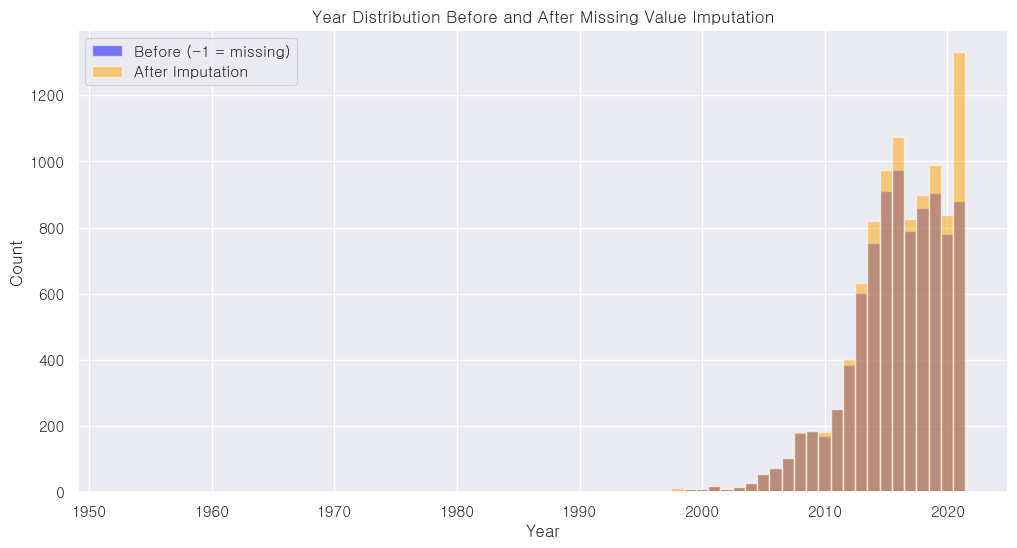

In [8]:
# -1로 대체(시각화용 temp)
year_before = df['year_backup'].fillna(-1)
year_after = df['year']

# 연도 구간만을 bins로 (음수 구간 제외)
real_year_min = int(min(year_before[year_before != -1].min(), year_after.min()))
real_year_max = int(max(year_before[year_before != -1].max(), year_after.max()))
bins = np.arange(real_year_min-0.5, real_year_max+1.5)

plt.figure(figsize=(12,6))
plt.hist(year_before, bins=bins,
         alpha=0.5, color='blue', label='Before (-1 = missing)')
plt.hist(year_after, bins=bins,
         alpha=0.5, color='orange', label='After Imputation')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Year Distribution Before and After Missing Value Imputation')
plt.legend()
plt.show()


결측치로 인해 빈공간이 많았던 연도에 값이 추가되어 분포가 자연스럽게 복원됨을 확인<br>
하지만 2020년도 이후에 결측치 대체가 많아 결측치 대체가 편향적으로 이어지지 않았음을 확인 예정

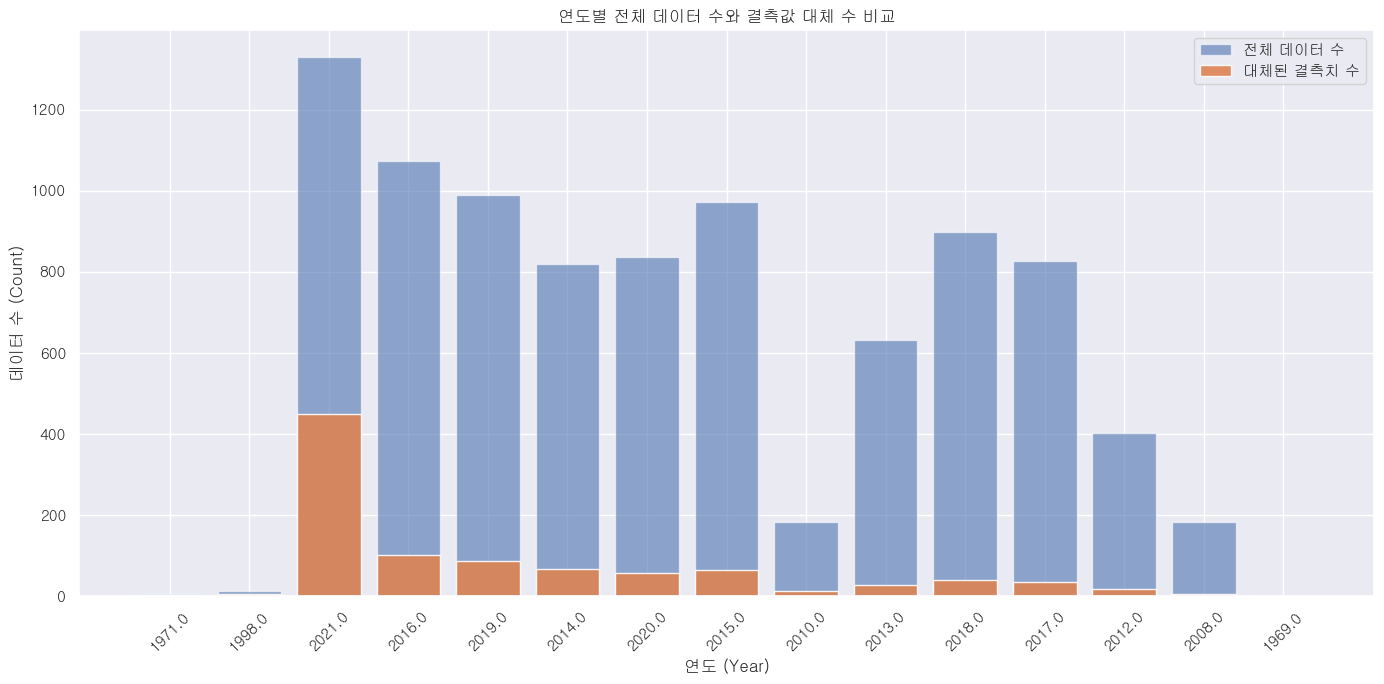

In [9]:
# 연도별 전체 데이터 수
overall = df['year'].value_counts().sort_index()

# 결측치였던 행들 중, 최종적으로 기록된 연도별 개수
imputed = df[df['was_missing']]['year'].value_counts().sort_index()

# 요약 테이블 생성
summary = pd.DataFrame({'all': overall, 'imputed': imputed})
summary['imputed'] = summary['imputed'].fillna(0)
summary['imputed_ratio'] = summary['imputed'] / summary['all']

# 대체비율 상위 15개 연도만 시각화
summary_sorted = summary.sort_values('imputed_ratio', ascending=False)
top_years = summary_sorted.head(15)

plt.figure(figsize=(14, 7))
plt.bar(top_years.index.astype(str), top_years['all'], label='전체 데이터 수', alpha=0.6)
plt.bar(top_years.index.astype(str), top_years['imputed'], label='대체된 결측치 수', alpha=0.9)

plt.xlabel('연도 (Year)')
plt.ylabel('데이터 수 (Count)')
plt.title('연도별 전체 데이터 수와 결측값 대체 수 비교')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


어느 한 연도에 결측치 대체가 극단적으로 집중된 흔적은 보이지 않음을 확인,<br>
결측치 대체가 지나치게 편향되지 않음을 확정<br>
year의 결측치 대체가 성공적이였음을 의미

### 전처리 motors_trim 컬럼

회사+모델로 그룹화하여 최빈값으로 결측치 대체 예정

In [10]:
# 1. motors_trim 컬럼 백업 
df['motors_trim_backup'] = df['motors_trim'].copy()

# 2. was_missing 플래그 생성 (결측치 여부)
df['motors_trim_was_missing'] = df['motors_trim_backup'].isnull()

# 3. 회사+모델별로 최빈 트림값으로 결측치 대체
def fill_with_mode(x):
    mode_vals = x.mode()
    if not mode_vals.empty:
        return x.fillna(mode_vals[0])
    else:
        return x.fillna('Unknown')

df['motors_trim'] = df.groupby(['company', 'model'])['motors_trim'].transform(fill_with_mode)

# 4. 혹시 남아있는 결측치는 'Unknown'으로 추가 대체
df['motors_trim'] = df['motors_trim'].fillna('Unknown')


In [11]:
# 대체되지 않아 Unknown값으로 대체 된 경우의 수 확인
print(df['motors_trim'].value_counts(dropna=False).head(10))
print('Unknown 비율:', (df['motors_trim'] == 'Unknown').mean())

motors_trim
Other       2200
Standard     432
SE           232
S            227
G 63 AMG     197
Sport        152
Limited      133
HSE          130
GLS          123
SV           114
Name: count, dtype: int64
Unknown 비율: 0.00010030090270812437


Unknown값으로 대체된경우는 0에 가깝거나 극히 미미하단 결과를 확인<br>
결측치 대체가 어느정도 잘 이루어졌다는 것을 증명<br>
시각화를 통해 전체적으로 잘 대체가 이루어졌는지 추가 확인

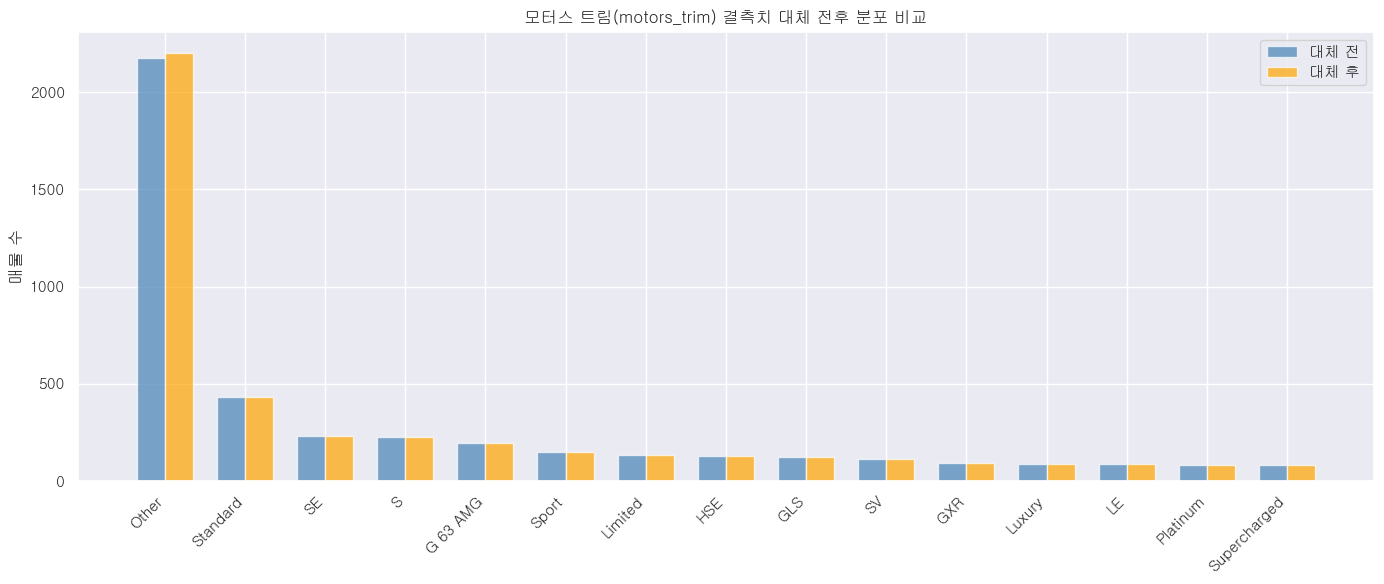

In [12]:
# 1. 상위 트림명만 추출
top_trim = df['motors_trim_backup'].value_counts().head(15).index

# 2. 결측치 대체 전후 
before_counts = df['motors_trim_backup'].fillna('결측치').value_counts().loc[top_trim]
after_counts = df['motors_trim'].value_counts().loc[top_trim]

bar_width = 0.35
idx = range(len(top_trim))

plt.figure(figsize=(14,6))
plt.bar(idx, before_counts, bar_width, label='대체 전', color='steelblue', alpha=0.7)
plt.bar([i + bar_width for i in idx], after_counts, bar_width, label='대체 후', color='orange', alpha=0.7)

plt.xticks([i + bar_width / 2 for i in idx], top_trim, rotation=45, ha='right')
plt.ylabel('매물 수')
plt.title('모터스 트림(motors_trim) 결측치 대체 전후 분포 비교')
plt.legend()
plt.tight_layout()
plt.show()


대체 전 후를 시각화를 통해 비교해 보았을 때 결측치 대체를 통해 데이터 왜곡, 훼손, 편향된 현상이 보이지 않음<br>
motors_trim의 결측치 대체가 잘 완료했음을 시사

### 전처리 no_of_cylinders와 horsepower - 1

도메인 지식으로 실린더(no_of_cylinders)와 마력(horsepower)가 강한 상관관계가 있다고 가설을 세움,<br>
마력의 문자형데이터를 숫자형데이터로 전처리를 해줘야한다고 판단

In [13]:
df['horsepower'].value_counts()

horsepower
200 - 300 HP        2432
300 - 400 HP        2208
400 - 500 HP        1279
150 - 200 HP        1222
500 - 600 HP        1027
Less than 150 HP     394
600 - 700 HP         391
700 - 800 HP         153
800 - 900 HP          30
900+ HP               20
Name: count, dtype: int64

In [14]:
def parse_horsepower_to_numeric_final(hp_str):
    """
    다양한 텍스트 기반 'horsepower' 값을 숫자(또는 NaN)로 변환.
    """
    if pd.isna(hp_str):
        return np.nan

    # 문자열로 변환 후 좌우 공백 및 소문자 변환
    hp_str = str(hp_str).strip()

    # 1. 쉼표/공백/소수점/전각 수치 등 정규화
    hp_str = hp_str.replace(',', '').replace('HP', '').strip()
    # 유니코드 대시/틸드 변환
    hp_str = re.sub(r'[~−–—]', '-', hp_str)

    # 2. '약' 또는 'approx', 'around', 'about' 등 들어간 경우: 숫자 추출
    if re.search(r'(약|approx|around|about)', hp_str, re.I):
        nums = re.findall(r'\d+', hp_str)
        if nums:
            return float(nums[0])

    # 3. 'N ~ M' 또는 'N- M', 'N~M' 등 범위 표기 모두 처리 (양쪽 공백, 유니코드 dash)
    match = re.match(r'(\d+)\s*-\s*(\d+)', hp_str)
    if not match:
        match = re.match(r'(\d+)\s*~\s*(\d+)', hp_str)
    if match:
        lower, upper = int(match.group(1)), int(match.group(2))
        return (lower + upper) / 2

    # 4. 'Less than N'
    if re.search(r'less than', hp_str, re.I):
        nums = re.findall(r'\d+', hp_str)
        if nums:
            return float(nums[0]) / 2

    # 5. 'N+' 또는 '+N'
    match = re.match(r'(\d+)\s*\+', hp_str)
    if not match:
        match = re.match(r'\+\s*(\d+)', hp_str)
    if match:
        return float(match.group(1)) + 50  

    # 6. 'HP N' 
    match = re.match(r'HP\s*(\d+)', hp_str, re.I)
    if match:
        return float(match.group(1))

    # 7. 소수점, 정수 등 숫자만 남은 경우
    nums = re.findall(r'\d+\.?\d*', hp_str)
    if nums and hp_str.replace('.', '', 1).isdigit():
        return float(nums[0])

    # 8. 변환 실패
    return np.nan


In [15]:
df['horsepower_numeric'] = df['horsepower'].apply(parse_horsepower_to_numeric_final)

In [16]:
# 숫자 변환 여부 결측치 현황 확인
print(df[['horsepower', 'horsepower_numeric']].head(10)) 

print("\nhorsepower_numeric 값의 요약:")
print(df['horsepower_numeric'].describe())

print("\n결측치 개수 :", df['horsepower_numeric'].isnull().sum())
print("유효 값 개수 :", df['horsepower_numeric'].notnull().sum())

         horsepower  horsepower_numeric
0               NaN                 NaN
1      400 - 500 HP               450.0
2      400 - 500 HP               450.0
3      600 - 700 HP               650.0
4  Less than 150 HP                75.0
5      200 - 300 HP               250.0
6               NaN                 NaN
7               NaN                 NaN
8      200 - 300 HP               250.0
9      200 - 300 HP               250.0

horsepower_numeric 값의 요약:
count    9156.000000
mean      347.094801
std       154.913242
min        75.000000
25%       250.000000
50%       350.000000
75%       450.000000
max       950.000000
Name: horsepower_numeric, dtype: float64

결측치 개수 : 814
유효 값 개수 : 9156


In [17]:
# horsepower_numeric이 NaN인 경우
print("\n숫자 변환 실패한 horsepower 값 샘플:")
print(df.loc[df['horsepower_numeric'].isnull(), 'horsepower'].drop_duplicates().head(10))



숫자 변환 실패한 horsepower 값 샘플:
0    NaN
Name: horsepower, dtype: object


In [18]:
df['no_of_cylinders'].value_counts()

no_of_cylinders
6     3325
4     2993
8     2986
12     366
3       56
10      53
5       53
Name: count, dtype: int64

horsepower의 전처리가 문제 없이 끝난 것을 확인, <br>
no_of_cylinder와 강한 상관관계가 있다는 가설을 입증하기 위해 시각화 

### EDA분석 no_of_cylinder와 horsepower 시각화

C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\3551152229.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


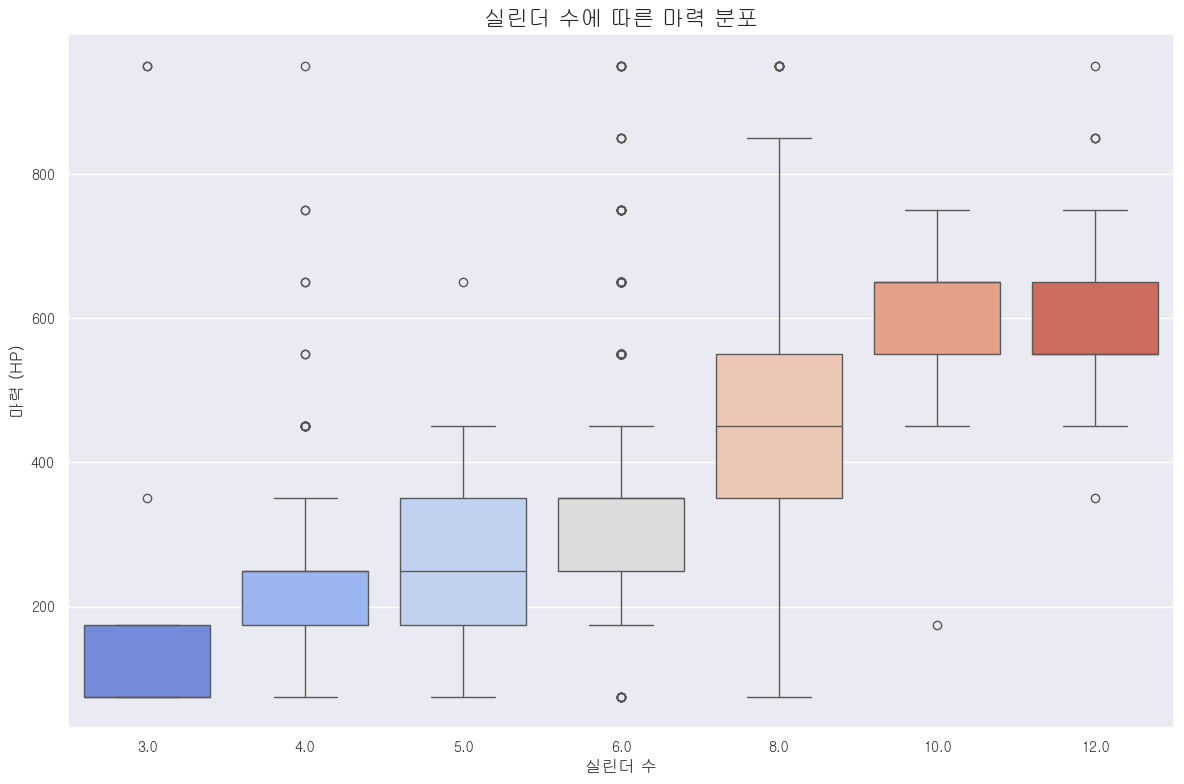

In [19]:
# 실린더 컬럼 numeric 자동 변환 
if 'no_of_cylinders_numeric' not in df.columns:
    df['no_of_cylinders_numeric'] = pd.to_numeric(df['no_of_cylinders'], errors='coerce')

# NaN 값 제외 후 클린 데이터 추출
df_cleaned_cyl_hp = df.dropna(subset=['no_of_cylinders_numeric', 'horsepower_numeric'])

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_cleaned_cyl_hp,
    x='no_of_cylinders_numeric',
    y='horsepower_numeric',
    palette='coolwarm'
)
plt.title('실린더 수에 따른 마력 분포', fontsize=16, fontweight='bold')
plt.xlabel('실린더 수', fontsize=12)
plt.ylabel('마력 (HP)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('cylinders_vs_horsepower.png')
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\582946192.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


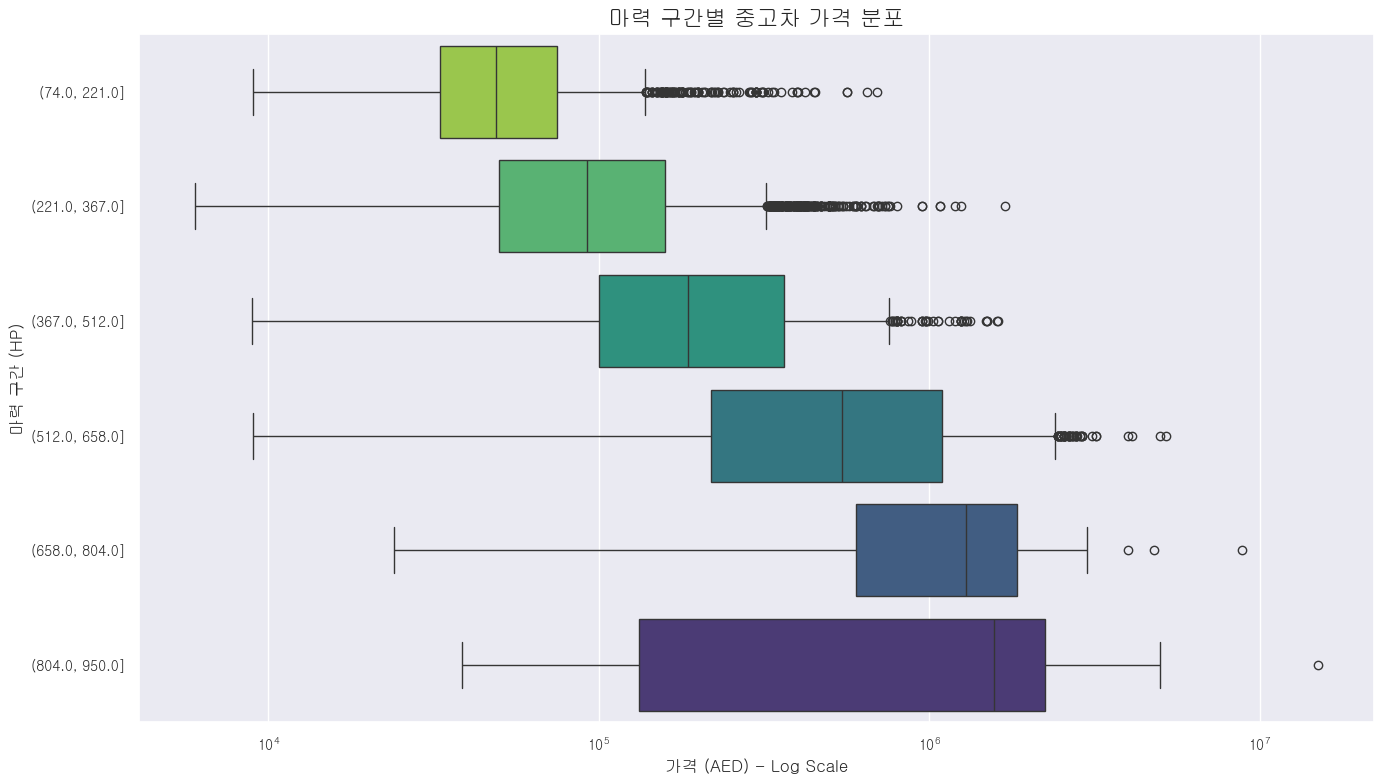

In [20]:
# 마력·가격 모두 결측치가 없는 데이터만 필터링
df_cleaned_hp_price = df.dropna(subset=['horsepower_numeric', 'price_in_aed']).copy()

# 마력 값을 6개 구간으로 나눔
num_bins = 6
df_cleaned_hp_price['horsepower_bins'] = pd.cut(
    df_cleaned_hp_price['horsepower_numeric'],
    bins=num_bins,
    precision=0
)

plt.figure(figsize=(14, 8))
sns.boxplot(
    data=df_cleaned_hp_price,
    x='price_in_aed',
    y='horsepower_bins',
    palette='viridis_r', 
    order=sorted(df_cleaned_hp_price['horsepower_bins'].unique(), key=lambda x: x.left)
)
plt.xscale('log')
plt.title('마력 구간별 중고차 가격 분포', fontsize=16, fontweight='bold')
plt.xlabel('가격 (AED) - Log Scale', fontsize=12)
plt.ylabel('마력 구간 (HP)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('horsepower_vs_price.png')
plt.show()


EDA 결과 실린더 수와 마력은 뚜렷한 양의 상관관계를 보이며, 이는 실린더 수와 마력이 강한 상관관계가 있다는 가설을 뒷받침할만한 자료라고 판단,<Br>
더 나아가 마력이 증가함에 따라 중고차 가격이 증가하는 강한 상관관계를 보이는 것을 확인,<br>
이는 마력이 중고차 가격을 예측하는 핵심 예측 변수중 하나로 판단됩니다

마력의 크기와 실린더의 갯수가 상관관계를 가지고 있다는 것을 박스플롯을 통해 확인,<br>
가설을 입증하기 위해 추가로 상관관계 분석을 실시함

--- 수치형 변수 간 상관계수 행렬 ---
                         price_in_aed  kilometers      year  \
price_in_aed                 1.000000   -0.028398  0.273089   
kilometers                  -0.028398    1.000000 -0.054301   
year                         0.273089   -0.054301  1.000000   
horsepower_numeric           0.565401   -0.008138  0.111861   
no_of_cylinders_numeric      0.476277    0.002385 -0.048429   

                         horsepower_numeric  no_of_cylinders_numeric  
price_in_aed                       0.565401                 0.476277  
kilometers                        -0.008138                 0.002385  
year                               0.111861                -0.048429  
horsepower_numeric                 1.000000                 0.750373  
no_of_cylinders_numeric            0.750373                 1.000000  

--- 상관관계 히트맵 시각화 ---


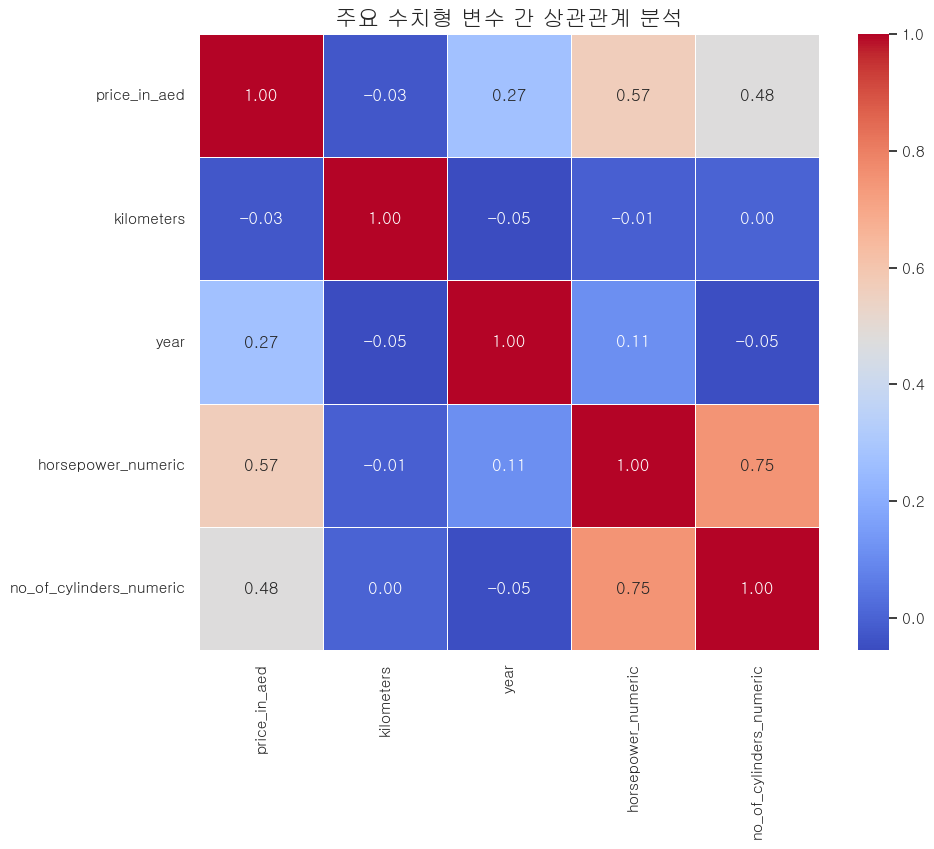

In [21]:
# --- 1. 분석에 사용할 숫자형 변수 선택 ---
numerical_cols = [
    'price_in_aed',
    'kilometers',
    'year',
    'horsepower_numeric',
    'no_of_cylinders_numeric'
]

# 선택된 열들로 새로운 데이터프레임 생성
df_corr = df[numerical_cols]

# --- 2. 상관계수 행렬 계산 ---
correlation_matrix = df_corr.corr()

print("--- 수치형 변수 간 상관계수 행렬 ---")
print(correlation_matrix)


# --- 3. 히트맵(Heatmap)으로 시각화 ---
print("\n--- 상관관계 히트맵 시각화 ---")
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,      
    cmap='coolwarm', 
    fmt='.2f',       
    linewidths=.5    
)
plt.title('주요 수치형 변수 간 상관관계 분석', fontsize=16, fontweight='bold')
plt.savefig('correlation_heatmap.png')
plt.show()


horsepower와 no_of_cylinders의 상관계수가 0.75로 다중공선성문제가 우려되 VIF검사 추가 실시

In [22]:
# --- 1. VIF 분석을 위한 독립 변수 선택 ---
vif_columns = [
    'kilometers', 
    'year', 
    'horsepower_numeric', 
    'no_of_cylinders_numeric'
]

print("--- VIF 분석 ---")

# --- 2. 분석용 임시 데이터프레임 생성 및 결측치 제거 ---
df_vif = df[vif_columns].dropna()

# --- 3. 상수항 추가 ---
df_vif_const = add_constant(df_vif)


# --- 4. VIF 계수 계산 ---
vif_data = pd.DataFrame()
vif_data["feature"] = df_vif_const.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif_const.values, i) for i in range(df_vif_const.shape[1])]


# --- 5. 결과 출력 ---
print("\n[VIF 계수 분석 결과]")
print(vif_data)


--- VIF 분석 ---

[VIF 계수 분석 결과]
                   feature            VIF
0                    const  200279.135959
1               kilometers       1.002882
2                     year       1.058842
3       horsepower_numeric       2.411410
4  no_of_cylinders_numeric       2.386179


horsepower와 no_of_cylinders 컬럼들의 상관계수가 0.75로 높게 나와 다중공선성 문제가 우려되어 VIF값을 구했지만,<br>
horsepower의 VIF값이 2.41, no_of_cylinders의 VIF값이 2.38으로 일반적으로 허용 가능한 수준의 VIF값으로, <br>
두 변수 모델간의 심각한 다중공선성 문제가 야기하지 않음을 판단 되었습니다.

따라서 horsepower와 no_of_cylinders의 강한 연관성을 고려해 두 변수의 결측치를 단순한 단일 값으로 대체하는 것이 아닌,<br>
두 변수간의 상호 정보를 확인하여 더 정확한 K-최근접이웃(KNN) 대체 기법을 활용하여 결측치를 채울 예정입니다.

### 전처리 no_of_cylinders와 horsepower - 2

In [23]:
# 1) 원본 df 복사본 생성 
df_knn = df.copy()

# 2) 대체 전 was_missing 플래그 생성 (각 변수별 결측치 위치 기록)
df_knn['no_of_cylinders_was_missing'] = df_knn['no_of_cylinders_numeric'].isnull()
df_knn['horsepower_was_missing'] = df_knn['horsepower_numeric'].isnull()

# 3) KNNImputer로 대체할 대상 추출 
impute_cols = ['no_of_cylinders_numeric', 'horsepower_numeric']

# 4) KNNImputer 초기화 (이웃 수 k=5, 평균 대체)
knn_imputer = KNNImputer(n_neighbors=5)

# 5) KNNImputer 적용 (결측치 대체)
df_knn_imputed = knn_imputer.fit_transform(df_knn[impute_cols])

# 6) 대체 결과를 복사본 저장
df_knn.loc[:, impute_cols] = df_knn_imputed

# 7) 대체 전후 비교용 원본 값 백업
if 'no_of_cylinders_numeric_backup' not in df_knn.columns:
    df_knn['no_of_cylinders_numeric_backup'] = df['no_of_cylinders_numeric'].copy()
if 'horsepower_numeric_backup' not in df_knn.columns:
    df_knn['horsepower_numeric_backup'] = df['horsepower_numeric'].copy()

# 8) 대체 결과 확인 
print("=== 결측치 전후 개수 비교 ===")
print(f"no_of_cylinders: 결측치 전 {df['no_of_cylinders_numeric'].isnull().sum()}개, 결측치 후 {df_knn['no_of_cylinders_numeric'].isnull().sum()}개")
print(f"horsepower: 결측치 전 {df['horsepower_numeric'].isnull().sum()}개, 결측치 후 {df_knn['horsepower_numeric'].isnull().sum()}개")

# 9) was_missing 플래그 활용
imputed_cylinders = df_knn[(df_knn['no_of_cylinders_was_missing']) & (~df_knn['no_of_cylinders_numeric'].isnull())]
imputed_horsepower = df_knn[(df_knn['horsepower_was_missing']) & (~df_knn['horsepower_numeric'].isnull())]

print(f"no_of_cylinders 대체된 행 수: {imputed_cylinders.shape[0]}")
print(f"horsepower 대체된 행 수: {imputed_horsepower.shape[0]}")


=== 결측치 전후 개수 비교 ===
no_of_cylinders: 결측치 전 138개, 결측치 후 0개
horsepower: 결측치 전 814개, 결측치 후 0개
no_of_cylinders 대체된 행 수: 138
horsepower 대체된 행 수: 814


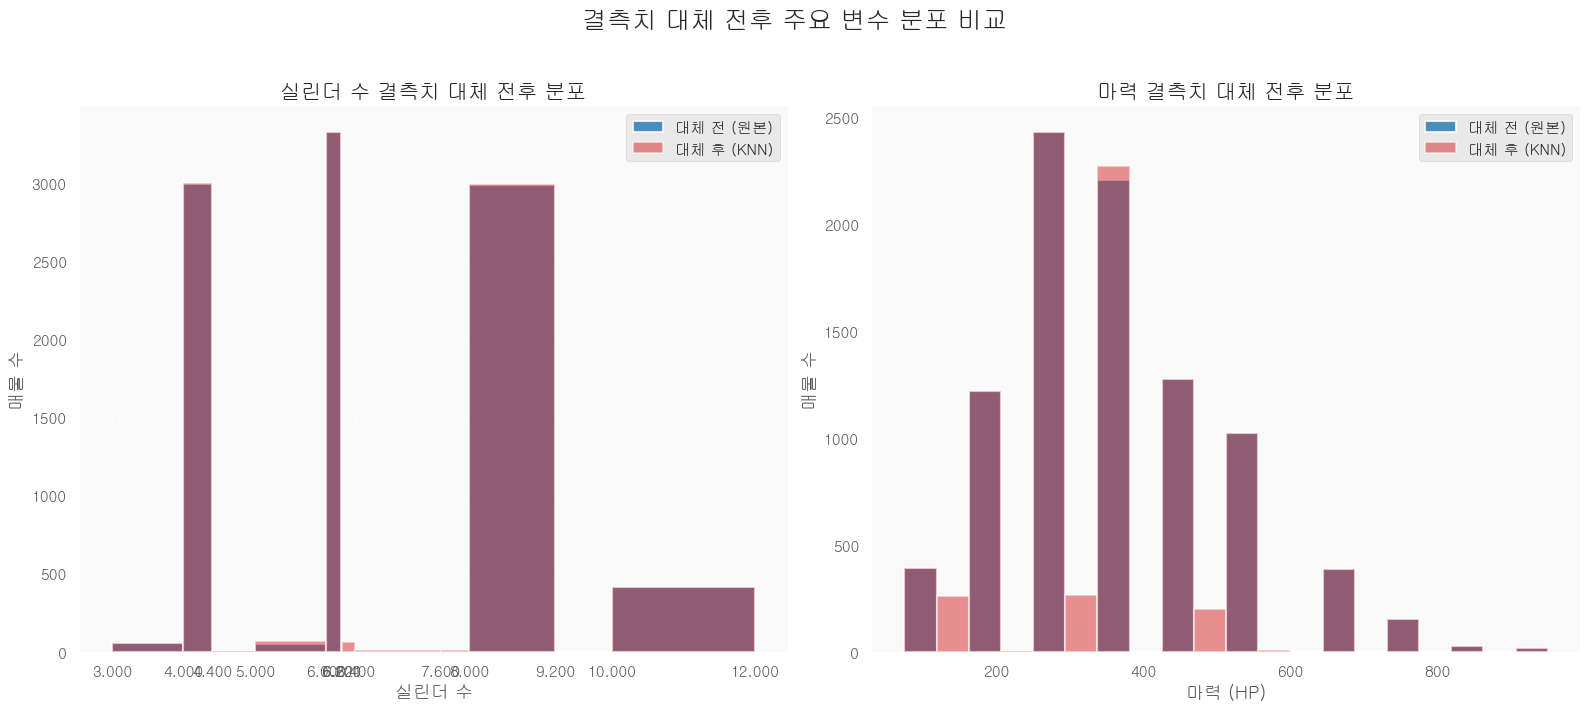

In [24]:
plt.style.use('ggplot') 

fig, axes = plt.subplots(1, 2, figsize=(16, 7), facecolor='white')

# --- 1. 실린더 수 결측치 대체 전후 ---
bins_cyl = sorted(set(df['no_of_cylinders_numeric'].dropna().unique()) | set(df_knn['no_of_cylinders_numeric'].dropna().unique()))
axes[0].hist(
    df['no_of_cylinders_numeric'].dropna(), bins=bins_cyl, 
    alpha=0.8, color='#1f77b4', label='대체 전 (원본)', 
    edgecolor='white', linewidth=1.5
)
axes[0].hist(
    df_knn['no_of_cylinders_numeric'].dropna(), bins=bins_cyl, 
    alpha=0.5, color='#d62728', label='대체 후 (KNN)', 
    edgecolor='white', linewidth=1.5
)
axes[0].set_xlabel('실린더 수', fontsize=13, fontweight='bold')
axes[0].set_ylabel('매물 수', fontsize=13, fontweight='bold')
axes[0].set_xticks(bins_cyl)
axes[0].set_title('실린더 수 결측치 대체 전후 분포', fontsize=15, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=11, frameon=True)
axes[0].tick_params(axis='both', labelsize=11)
axes[0].grid(True, linestyle='--', alpha=0.6)

# --- 2. 마력 결측치 대체 전후 ---
all_hp = np.concatenate([df['horsepower_numeric'].dropna(), df_knn['horsepower_numeric'].dropna()])
bins_hp = np.histogram_bin_edges(all_hp, bins=20)

axes[1].hist(
    df['horsepower_numeric'].dropna(), bins=bins_hp,
    alpha=0.8, color='#1f77b4', label='대체 전 (원본)',
    edgecolor='white', linewidth=1.5
)
axes[1].hist(
    df_knn['horsepower_numeric'].dropna(), bins=bins_hp,
    alpha=0.5, color='#d62728', label='대체 후 (KNN)',
    edgecolor='white', linewidth=1.5
)
axes[1].set_xlabel('마력 (HP)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('매물 수', fontsize=13, fontweight='bold')
axes[1].set_title('마력 결측치 대체 전후 분포', fontsize=15, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=11, frameon=True)
axes[1].tick_params(axis='both', labelsize=11)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.suptitle('결측치 대체 전후 주요 변수 분포 비교', fontsize=18, fontweight='bold', y=1.03)
plt.tight_layout(rect=[0, 0.02, 1, 1])

for ax in axes:
    ax.set_facecolor('#f9f9f9')
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.show()


두 변수 모두 KNN 대체 후에도 원본 데이터와 거의 동일한 모습을 확인,<br>
특정 값으로 과도한 쏠림, 분포의 왜곡, 이상치 증가는 보이지 않음<br>
성공적인 결측치 처리임을 시각화를 통해 확인

### EDA분석 title

--- 'model' 컬럼의 고유(unique) 모델 개수: 552개 ---

--- 가장 빈도가 높은 상위 20개 모델 ---
model
patrol               399
s-class              269
g-class              259
range-rover-sport    208
land-cruiser         200
c-class              192
range-rover          187
e-class              181
pajero               152
charger              140
cayenne              140
7-series             127
grand-cherokee       117
mustang              117
other                115
carrera              114
x5                   110
wrangler             106
f-series-pickup      101
altima               101
Name: count, dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\3609527780.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_20_models.index, x=top_20_models.values, palette='viridis')


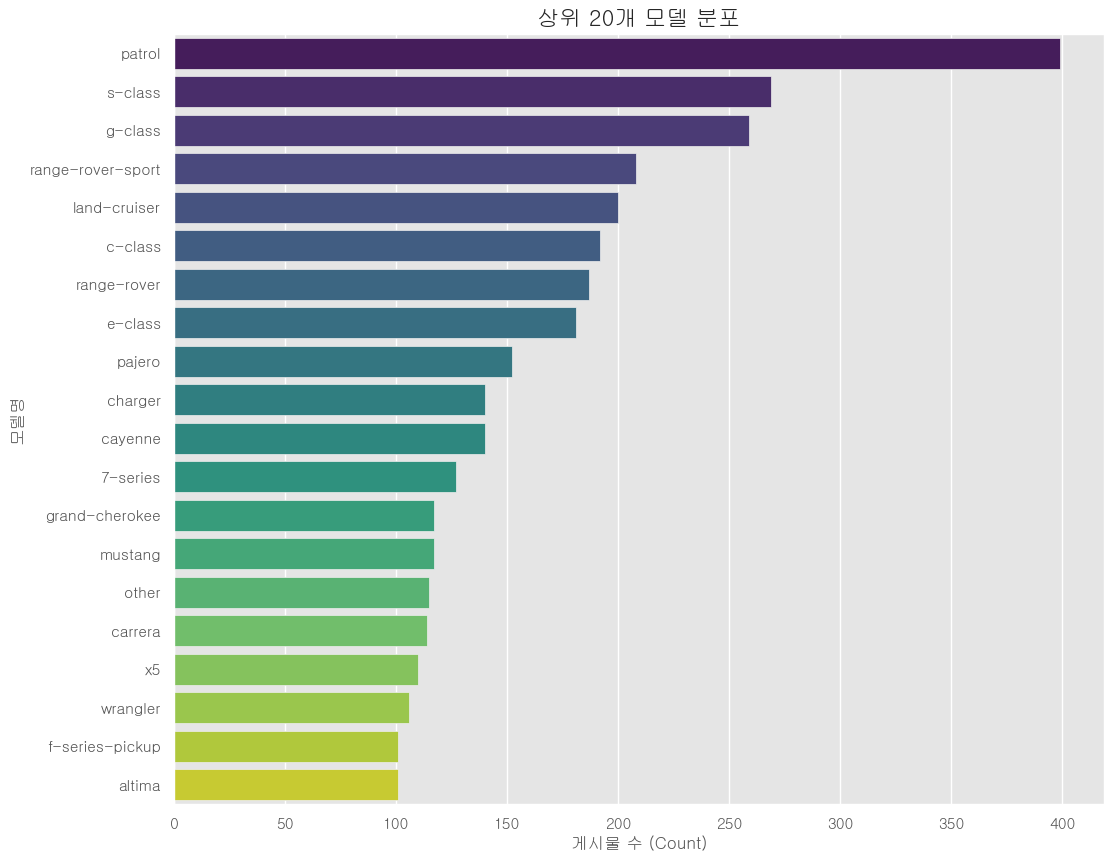

In [25]:
# --- 1. 'model' 컬럼의 고유값 개수 확인 ---
model_cardinality = df['model'].nunique()
print(f"--- 'model' 컬럼의 고유(unique) 모델 개수: {model_cardinality}개 ---")

# --- 2. 가장 빈도가 높은 상위 20개 모델 확인 ---
print("\n--- 가장 빈도가 높은 상위 20개 모델 ---")
top_20_models = df['model'].value_counts().head(20)
print(top_20_models)

# --- 3. 상위 20개 모델 분포 시각화 ---
plt.figure(figsize=(12, 10))
sns.barplot(y=top_20_models.index, x=top_20_models.values, palette='viridis')
plt.title('상위 20개 모델 분포', fontsize=16)
plt.xlabel('게시물 수 (Count)', fontsize=12)
plt.ylabel('모델명', fontsize=12)
plt.show()

EDA분석 결과 title에는 광고문구등 불필요한 정보가 포함되어 있어,<br>
모델학습에 혼란을 야기할 것이라 판단, <br>
title컬럼 삭제 판단

### 전처리 title

In [26]:
if 'title' in df.columns:
    df = df.drop(columns=['title'])
    print("title 컬럼이 삭제되었습니다.")
else:
    print("title 컬럼이 존재하지 않아 삭제를 생략합니다.")

title 컬럼이 삭제되었습니다.


In [27]:
print("현재 데이터프레임 컬럼 목록:", df.columns.tolist())

현재 데이터프레임 컬럼 목록: ['price_in_aed', 'kilometers', 'body_condition', 'mechanical_condition', 'seller_type', 'body_type', 'no_of_cylinders', 'transmission_type', 'regional_specs', 'horsepower', 'fuel_type', 'steering_side', 'year', 'color', 'emirate', 'motors_trim', 'company', 'model', 'date_posted', 'year_backup', 'was_missing', 'motors_trim_backup', 'motors_trim_was_missing', 'horsepower_numeric', 'no_of_cylinders_numeric']


### EDA price_in_aed -1 

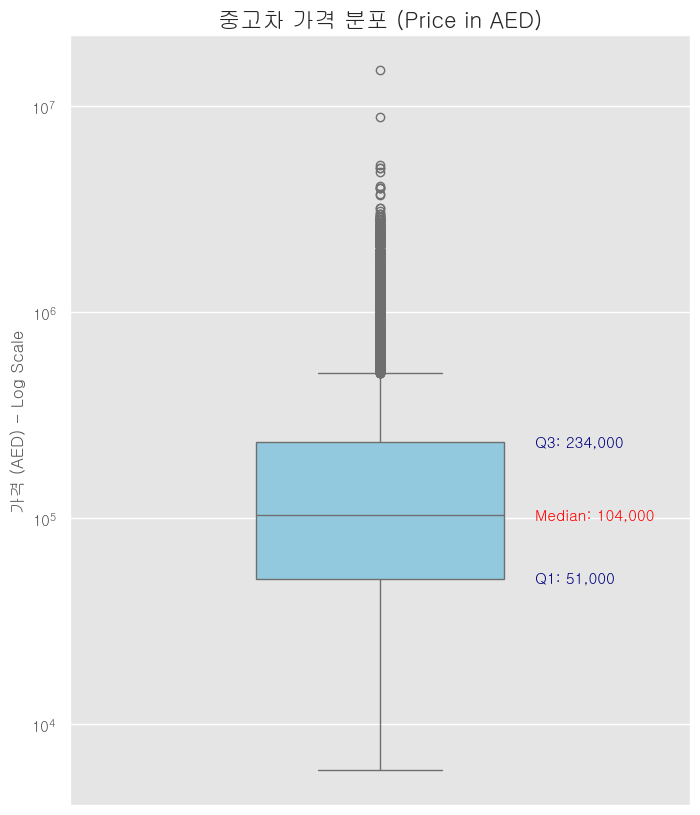

In [28]:
# --- 1. price_in_aed 박스플롯 ---
plt.figure(figsize=(8, 10))

ax1 = sns.boxplot(y=df['price_in_aed'], color='skyblue', width=0.4)

price_median = df['price_in_aed'].median()
price_q1 = df['price_in_aed'].quantile(0.25)
price_q3 = df['price_in_aed'].quantile(0.75)

plt.text(0.25, price_q3, f'Q3: {price_q3:,.0f}', va='center', ha='left', fontsize=11, color='navy')
plt.text(0.25, price_median, f'Median: {price_median:,.0f}', va='center', ha='left', fontsize=11, fontweight='bold', color='red')
plt.text(0.25, price_q1, f'Q1: {price_q1:,.0f}', va='center', ha='left', fontsize=11, color='navy')

plt.title('중고차 가격 분포 (Price in AED)', fontsize=16, fontweight='bold')
plt.ylabel('가격 (AED) - Log Scale', fontsize=12)
plt.yscale('log')
plt.xticks([]) 
plt.show()


price_in_aed에서 심하게 오른쪽으로 쳐져있는 특성을 확인, 로그변혼을 적용<br>
price_in_aed에 이상치가 극단적인 값이 관측되어 이상치 존재 가능성이 재기,<br>
boxplot으로 이상치를 시각적으로 확인한 결과, price_in_aed는 실제 최고급 매물이나 고급 스포츠 카가 있을 경우가 있어 이상치가 존재한다 가설 수립,<br>

### 전처리 price_in_aed -1

In [29]:
# price_in_aed 로그변환 새로운 컬럼을 만들어 사용
# 음수/0 값 방지: 조건 필터 또는 log1p 사용
df = df[df['price_in_aed'] > 0]  
df['log_price_in_aed'] = np.log(df['price_in_aed'])

In [30]:
print(df[['price_in_aed', 'log_price_in_aed']].head())

   price_in_aed  log_price_in_aed
0         26000         10.165852
1        110000         11.608236
2         78000         11.264464
3        899000         13.709038
4         33000         10.404263


### EDA price_in_aed -2

C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\386853775.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


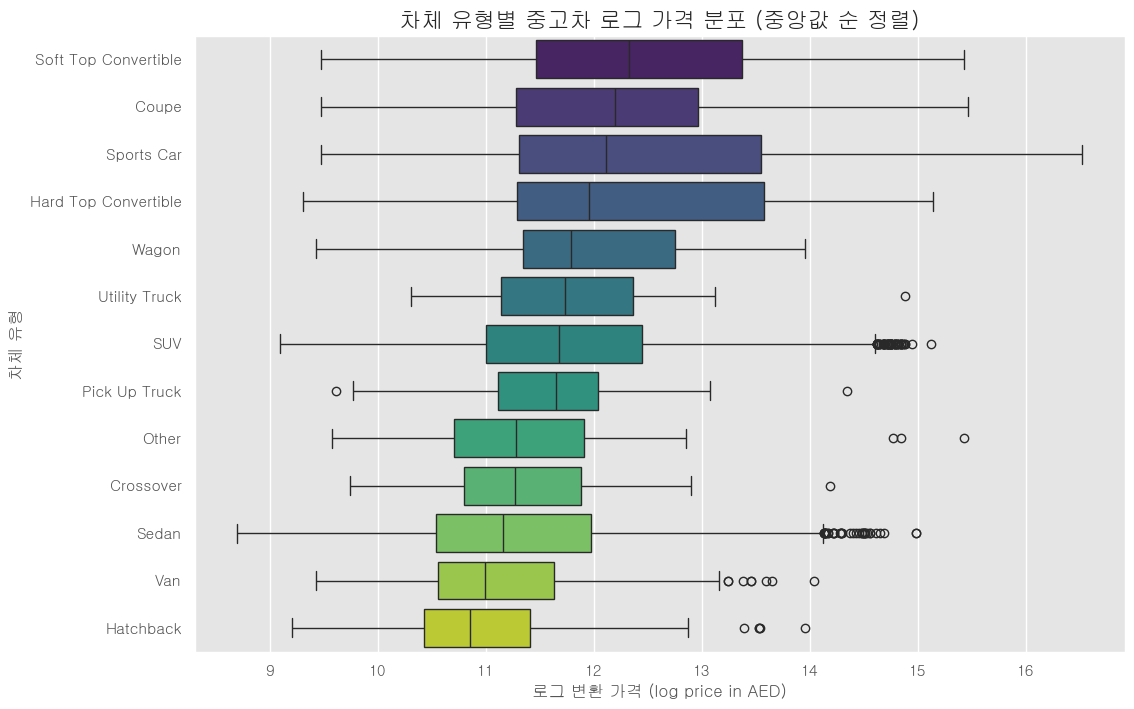

In [31]:
# body_type에 따른 가격 변화
plt.figure(figsize=(12, 8))
body_type_order = df.groupby('body_type')['log_price_in_aed'].median().sort_values(ascending=False).index

sns.boxplot(
    data=df,
    x='log_price_in_aed',
    y='body_type',
    order=body_type_order,
    palette='viridis'
)
plt.title('차체 유형별 중고차 로그 가격 분포 (중앙값 순 정렬)', fontsize=16, fontweight='bold')
plt.xlabel('로그 변환 가격 (log price in AED)', fontsize=12)
plt.ylabel('차체 유형', fontsize=12)
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\2118612607.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


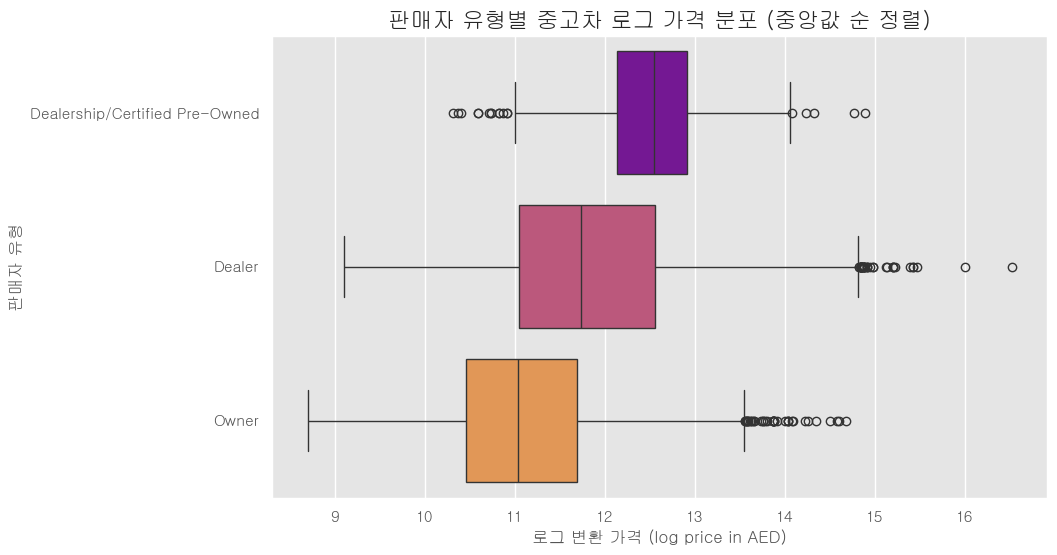

In [32]:
# seller_type에 따른 가격 변화
plt.figure(figsize=(10, 6))
seller_type_order = df.groupby('seller_type')['log_price_in_aed'].median().sort_values(ascending=False).index

sns.boxplot(
    data=df,
    x='log_price_in_aed',
    y='seller_type',
    order=seller_type_order,
    palette='plasma'
)
plt.title('판매자 유형별 중고차 로그 가격 분포 (중앙값 순 정렬)', fontsize=16, fontweight='bold')
plt.xlabel('로그 변환 가격 (log price in AED)', fontsize=12)
plt.ylabel('판매자 유형', fontsize=12)
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\3682761721.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


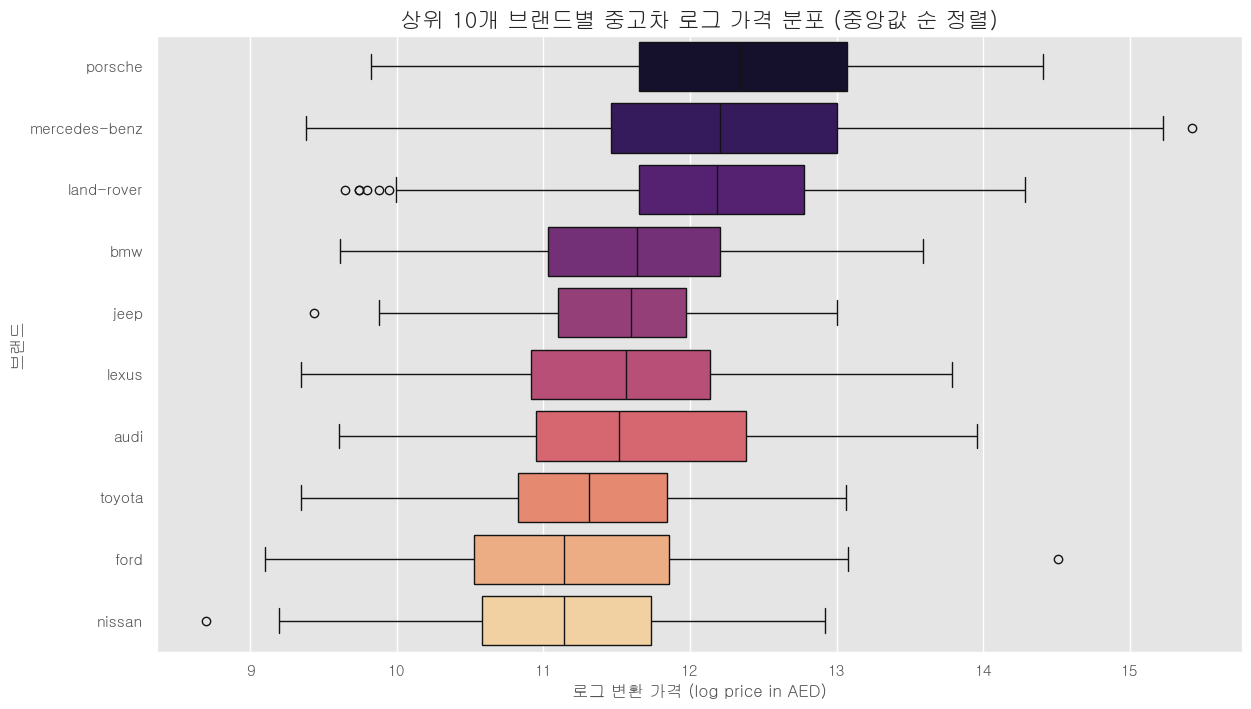

In [33]:
# 상위10개company에 따른 가격변화
top_10_companies = df['company'].value_counts().head(10).index
df_top10 = df[df['company'].isin(top_10_companies)]

plt.figure(figsize=(14, 8))
company_order = df_top10.groupby('company')['log_price_in_aed'].median().sort_values(ascending=False).index

sns.boxplot(
    data=df_top10,
    x='log_price_in_aed',
    y='company',
    order=company_order,
    palette='magma'
)
plt.title('상위 10개 브랜드별 중고차 로그 가격 분포 (중앙값 순 정렬)', fontsize=16, fontweight='bold')
plt.xlabel('로그 변환 가격 (log price in AED)', fontsize=12)
plt.ylabel('브랜드', fontsize=12)
plt.show()


EDA 분석 결과 중고차 가격 내 이상치가 스포츠카와 같은 고급 모델, 프리미엄 브랜드가 주요 원인임을 확인 <br>
'price_in_aed는 실제 최고급 매물이나 고급 스포츠 카가 있을 경우가 있어 이상치가 존재한다'라는 기존의 가설을 입증

### 전처리 price_in_aed -2

In [34]:
# 스케일링
# 1. 스케일러 객체 생성
scaler = StandardScaler()

df['scaled_log_price_in_aed'] = scaler.fit_transform(df[['log_price_in_aed']])

print(df[['log_price_in_aed', 'scaled_log_price_in_aed']].head())

   log_price_in_aed  scaled_log_price_in_aed
0         10.165852                -1.337099
1         11.608236                -0.058839
2         11.264464                -0.363494
3         13.709038                 1.802920
4         10.404263                -1.125816


In [35]:
print(df[['log_price_in_aed', 'scaled_log_price_in_aed']].isnull().sum())

log_price_in_aed           0
scaled_log_price_in_aed    0
dtype: int64


### EDA bdoy_type, company, seller_type

C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\369721402.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.countplot(data=df, y='body_type',


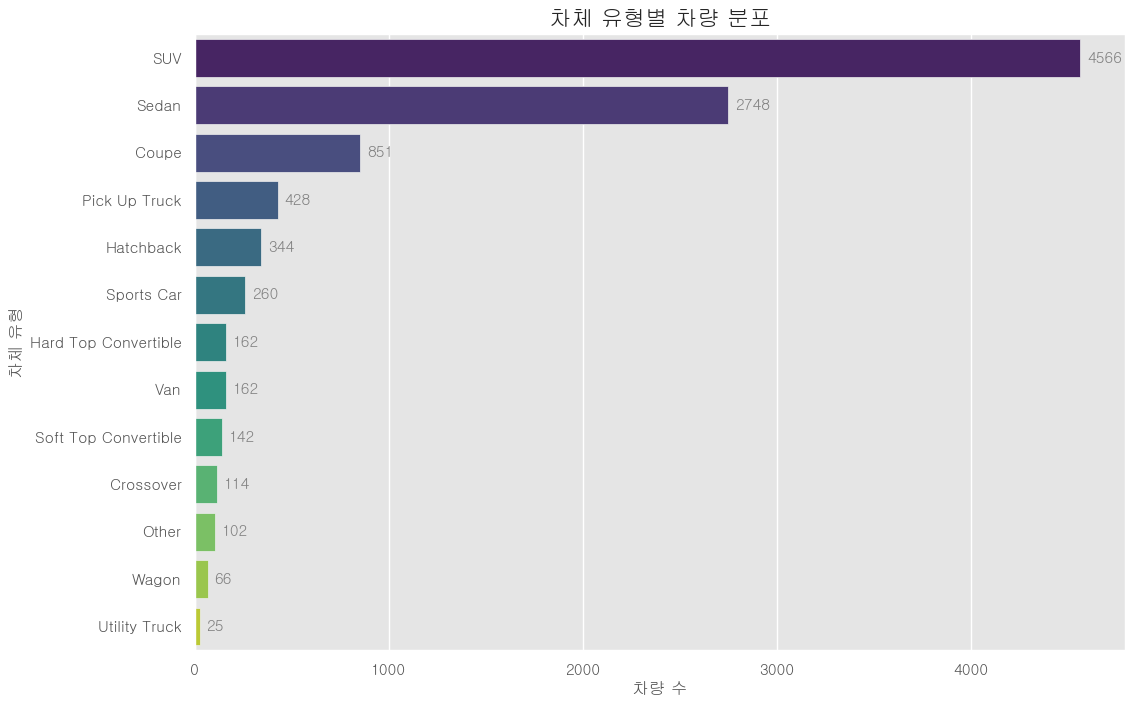

In [36]:
# ---  'body_type' 컬럼의 차체 유형별 차량 수 ---
plt.figure(figsize=(12, 8))

ax1 = sns.countplot(data=df, y='body_type', 
                    order=df['body_type'].value_counts().index,
                    palette='viridis')

plt.title('차체 유형별 차량 분포', fontsize=16, fontweight='bold')
plt.xlabel('차량 수', fontsize=12)
plt.ylabel('차체 유형', fontsize=12)

for p in ax1.patches:
    ax1.annotate(f'{int(p.get_width())}', 
                   (p.get_width(), p.get_y() + p.get_height() / 2.), 
                   ha='left', va='center', fontsize=11, color='gray', xytext=(5, 0),
                   textcoords='offset points')
plt.show()

body_type컬럼의 분포 분석결과 SUV, SEDAN, COUPE 3가지 차체 유형이 전체 데이터에서  압도적인 비중을 차지하며 유의미한 분포를 보임

C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\1639912618.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(data=df, y='company',


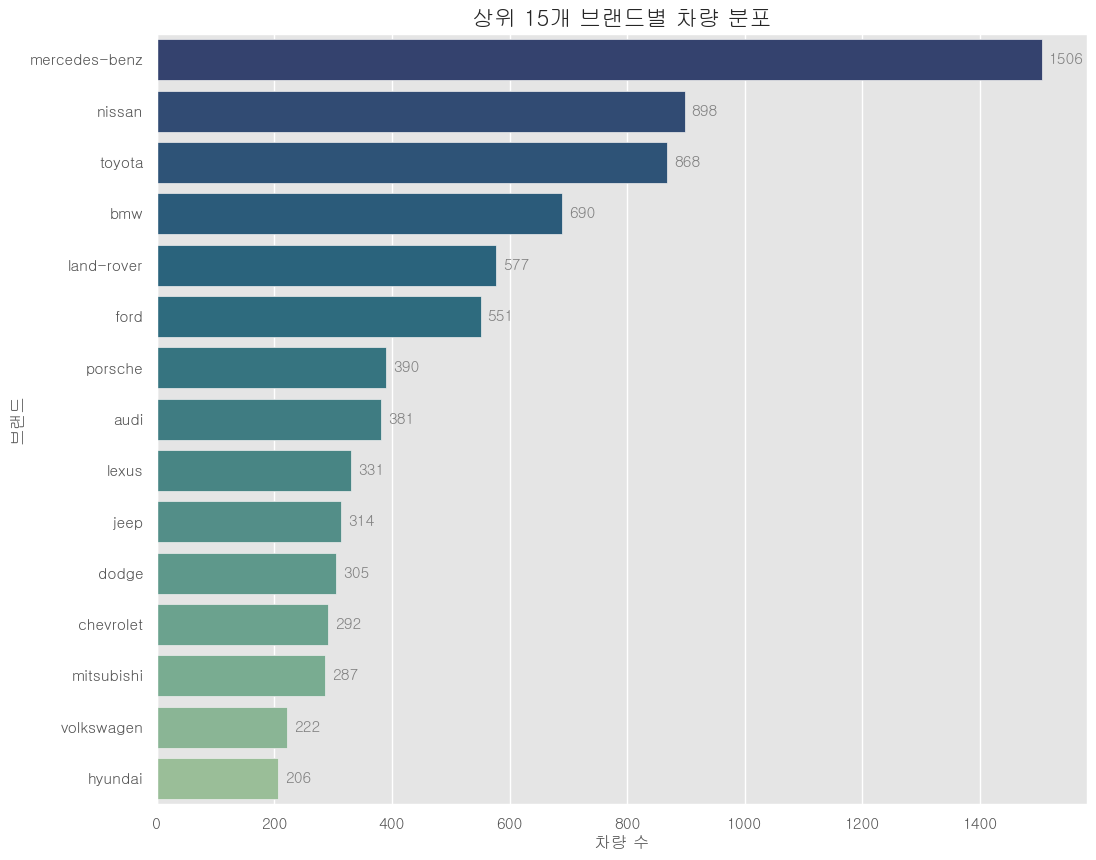

In [37]:
# --- 'company' (브랜드) 컬럼의 차량 수 ---
plt.figure(figsize=(12, 10))

# 상위 15개 브랜드만 선택
top_15_companies = df['company'].value_counts().index[:15]

ax2 = sns.countplot(data=df, y='company', 
                    order=top_15_companies,
                    palette='crest_r') 

plt.title('상위 15개 브랜드별 차량 분포', fontsize=16, fontweight='bold')
plt.xlabel('차량 수', fontsize=12)
plt.ylabel('브랜드', fontsize=12)

for p in ax2.patches:
    ax2.annotate(f'{int(p.get_width())}', 
                   (p.get_width(), p.get_y() + p.get_height() / 2.), 
                   ha='left', va='center', fontsize=11, color='gray', xytext=(5, 0),
                   textcoords='offset points')
plt.show()

company컬럼의 분포 분석결과 벤츠가 가장 높은 비율을 보였지만 그 외 다수의 브랜드들 역시 중요한 시장 점유율과 유의미한 차량수를 보유하고 있음을 확인

C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\2118612607.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


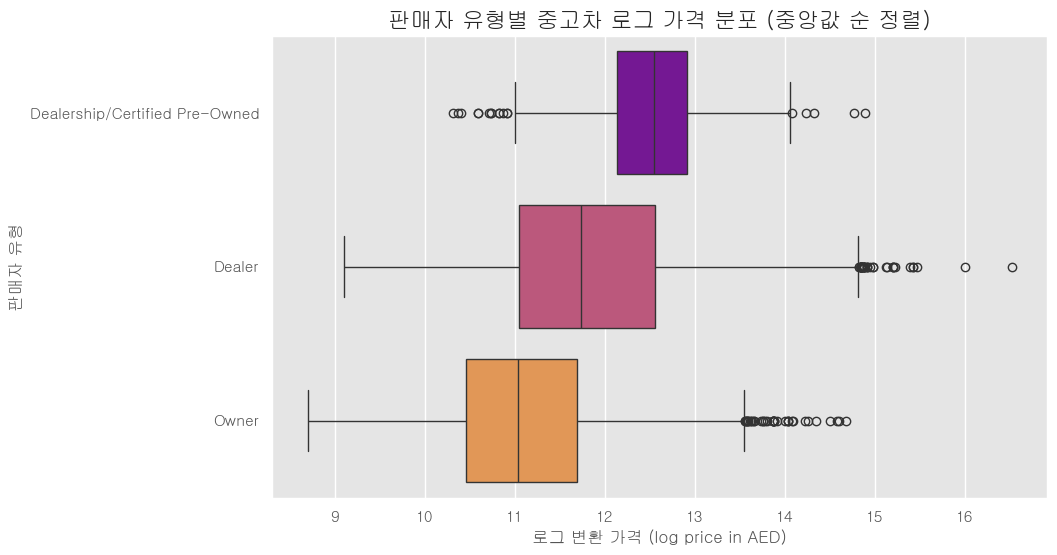

In [38]:
# seller_type에 따른 가격 변화
plt.figure(figsize=(10, 6))
seller_type_order = df.groupby('seller_type')['log_price_in_aed'].median().sort_values(ascending=False).index

sns.boxplot(
    data=df,
    x='log_price_in_aed',
    y='seller_type',
    order=seller_type_order,
    palette='plasma'
)
plt.title('판매자 유형별 중고차 로그 가격 분포 (중앙값 순 정렬)', fontsize=16, fontweight='bold')
plt.xlabel('로그 변환 가격 (log price in AED)', fontsize=12)
plt.ylabel('판매자 유형', fontsize=12)
plt.show()


각각의 판매자 유형에 따라 시장 내 가격 결정에 중요한 결정을 따른 다는 것을 확인

### 전처리 bdoy_type, company, seller_type

In [39]:
# body_type 전처리

# 1. 상위 3개 차체 유형 추출
top3_types = df['body_type'].value_counts().head(3).index

# 2. 나머지는 'Other'로 변환
df['body_type_grouped'] = df['body_type'].apply(lambda x: x if x in top3_types else 'Other')

# 3. 원-핫 인코딩 (drop_first=True: 다중공선성 방지, 원하면 False 가능)
df = pd.get_dummies(df, columns=['body_type_grouped'], prefix='body', drop_first=False)

# 컬럼 확인용
print(df.filter(like='body_type').head())


              body_type
0                   SUV
1                   SUV
2                 Sedan
3  Hard Top Convertible
4                 Wagon


In [40]:
# company 전처리

# 타겟 인코딩: company별 평균 log_price_in_aed로 치환
company_encoding = df.groupby('company')['log_price_in_aed'].mean()

df['company_te'] = df['company'].map(company_encoding)

global_mean = df['log_price_in_aed'].mean()
df['company_te'] = df['company_te'].fillna(global_mean)

# 결과 확인
print(df[['company', 'log_price_in_aed', 'company_te']].head())


         company  log_price_in_aed  company_te
0     mitsubishi         10.165852   10.696898
1      chevrolet         11.608236   11.150613
2  mercedes-benz         11.264464   12.236476
3        ferrari         13.709038   13.820785
4        renault         10.404263   10.496333


In [41]:
# seller_type 전처리

# seller_type 컬럼의 원-핫 인코딩 적용
df = pd.get_dummies(df, columns=['seller_type'], prefix='seller', drop_first=False)

### EDA Kilometer

In [42]:
print((df['kilometers'] <= 0).sum())

798


In [43]:
# 주행거리가 음수인 이상치를 발견해 이상치 선 제거
df = df[df['kilometers'] > 0].copy()
print(f"주행거리 0 이하 데이터 제거 후 남은 행 개수: {len(df)}")

주행거리 0 이하 데이터 제거 후 남은 행 개수: 9172


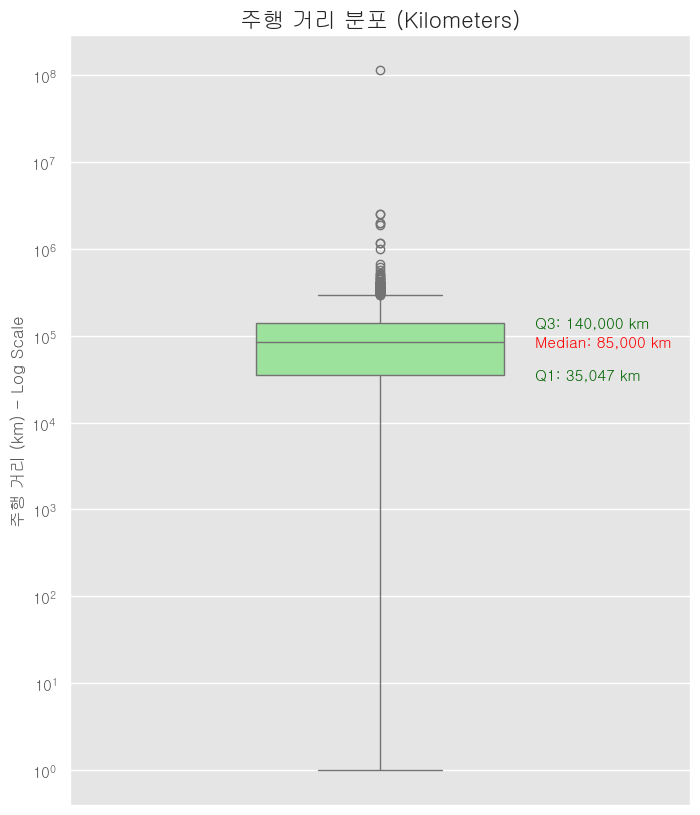

In [44]:
# --- kilometers 박스플롯  ---
plt.figure(figsize=(8, 10))

ax2 = sns.boxplot(y=df['kilometers'], color='lightgreen', width=0.4)

km_median = df['kilometers'].median()
km_q1 = df['kilometers'].quantile(0.25)
km_q3 = df['kilometers'].quantile(0.75)

plt.text(0.25, km_q3, f'Q3: {km_q3:,.0f} km', va='center', ha='left', fontsize=11, color='darkgreen')
plt.text(0.25, km_median, f'Median: {km_median:,.0f} km', va='center', ha='left', fontsize=11, fontweight='bold', color='red')
plt.text(0.25, km_q1, f'Q1: {km_q1:,.0f} km', va='center', ha='left', fontsize=11, color='darkgreen')

plt.title('주행 거리 분포 (Kilometers)', fontsize=16, fontweight='bold')
plt.ylabel('주행 거리 (km) - Log Scale', fontsize=12)
plt.yscale('log')
plt.xticks([])
plt.show()

EDA 분석결과 kilometer에 음수값이라는 이상치가 있어 제거, 박스플롯을 찍어보니 단 1건의 비정상적인 이상치를 판단

### 전처리 kilometers

In [45]:
# 주행거리 값 내림차순 정렬로 최댓값 확인
max_km = df['kilometers'].max()
print('극단값(최대 주행거리):', max_km)

# 해당 극단값 1건만 제거
df = df[df['kilometers'] != max_km].copy()

print(f"극단치 1건 삭제 후 남은 행: {len(df)}")

극단값(최대 주행거리): 115000000
극단치 1건 삭제 후 남은 행: 9171


### EDA 보조변수

C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\142008166.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=ax, order=df[col].value_counts().index, palette='plasma')
C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\142008166.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=ax, order=df[col].value_counts().index, palette='plasma')
C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\142008166.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=ax, order=df[col].value_count

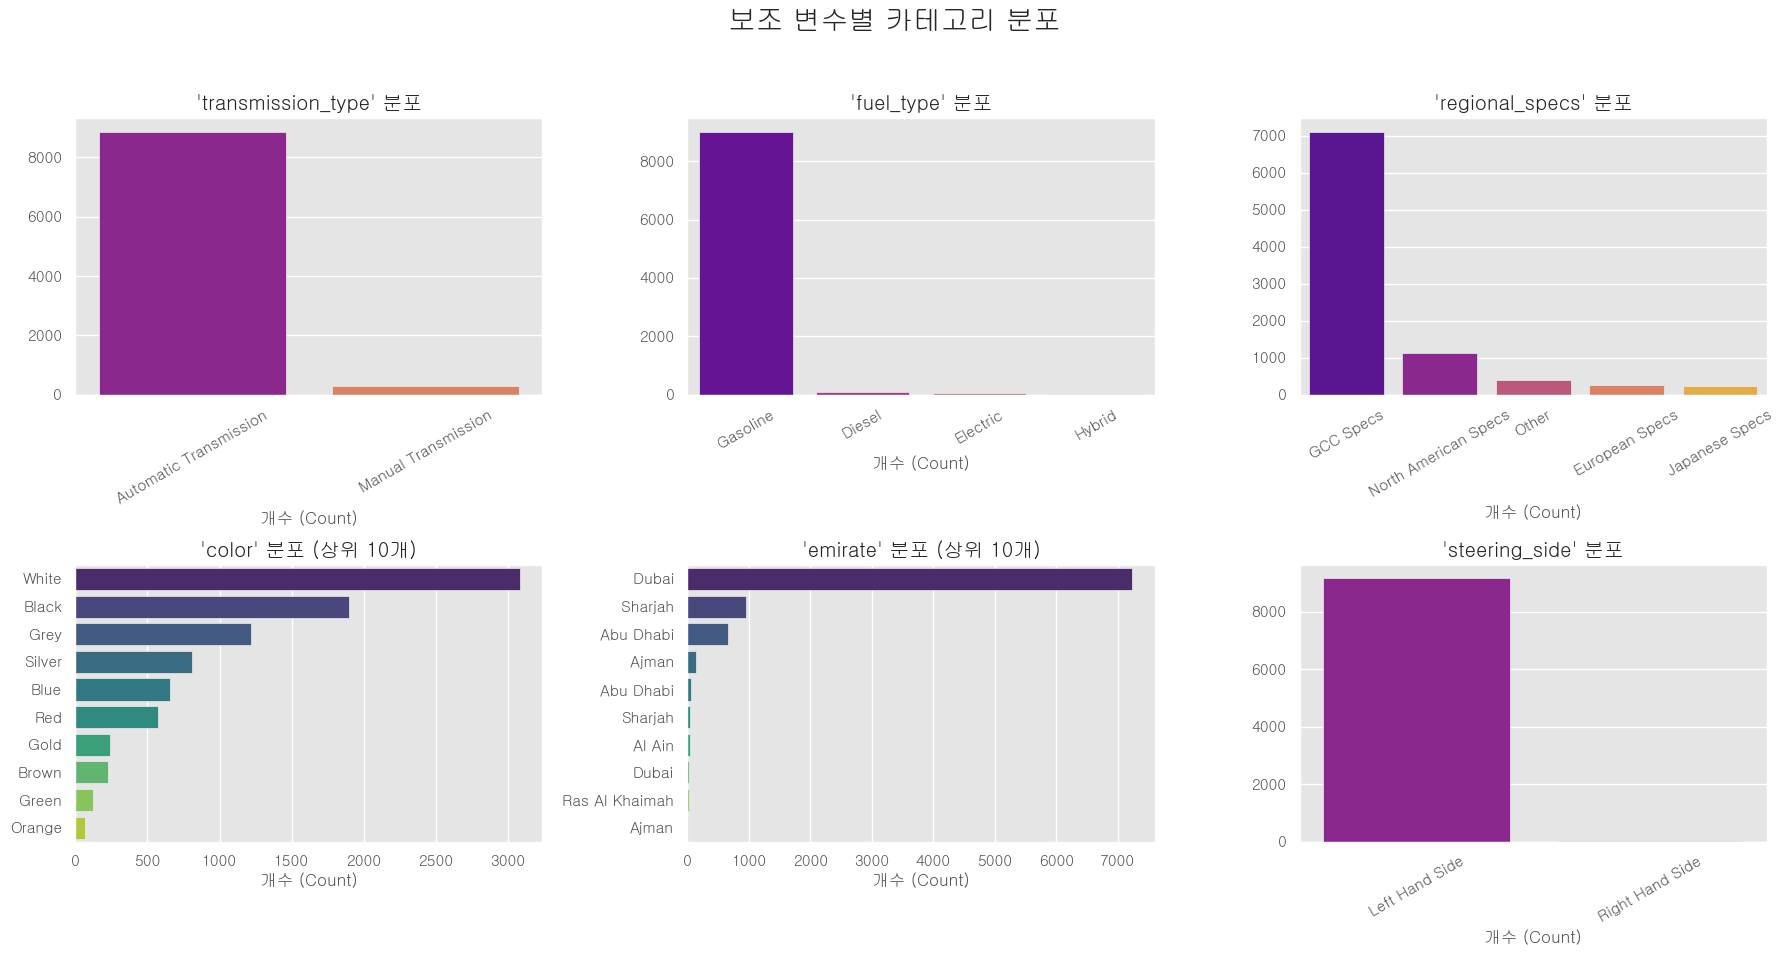

In [46]:
# 분석할 보조 변수들의 리스트
categorical_cols = [
    'transmission_type', 
    'fuel_type', 
    'regional_specs', 
    'color', 
    'emirate',
    'steering_side'
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('보조 변수별 카테고리 분포', fontsize=20, fontweight='bold')

for i, col in enumerate(categorical_cols):
    ax = axes[i//3, i%3]
    
    # 카테고리가 많은 'color'와 'emirate'는 상위 10개만 표시
    if df[col].nunique() > 10:
        order = df[col].value_counts().nlargest(10).index
        sns.countplot(data=df, y=col, ax=ax, order=order, palette='viridis')
        ax.set_title(f"'{col}' 분포 (상위 10개)")
    else:
        sns.countplot(data=df, x=col, ax=ax, order=df[col].value_counts().index, palette='plasma')
        ax.set_title(f"'{col}' 분포")
        ax.tick_params(axis='x', rotation=30) 
    
    ax.set_xlabel('개수 (Count)')
    ax.set_ylabel('')

if len(categorical_cols) < 6:
    axes[1, 2].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('distributions_grid.png')
plt.show()

EDA 분석결과 transmission_type은 자동 변속기가 압도적으로 많고<br>
fuel_type에선 가솔린이 대부분을 차지하며, 디젤과 하이브리드 등은 소수에 불과한 것을 확인<br>
regional_specs도 GCC규격 차량이 압도적인 비율을 가지고있으며 기타지역은 희소한 것을 파악<br>
color 은 흰색 검은색, 회색이 주요 색상으로 전체 색상 중 높은 빈도를 보인 것을 확인 <br>
emirate는 두바이, 샤르자, 아부다비가 높은 점유율을 차지하며, 나머지 지역은 상대적을로 적은 비중을 확인<br>
steering_side에선 대부분 좌측 핸들 차량을 구성

### 전처리 보조변수

In [47]:
# transmission_type 전처리
# transmission_type 최빈값 확인
top_transmission = df['transmission_type'].mode()[0]

# 이진화: 최빈값은 1, 나머지는 0
df['transmission_type_bin'] = df['transmission_type'].apply(lambda x: 1 if x == top_transmission else 0)

# 확인
print(df[['transmission_type', 'transmission_type_bin']].value_counts())


transmission_type       transmission_type_bin
Automatic Transmission  1                        8875
Manual Transmission     0                         296
Name: count, dtype: int64


In [48]:
# fuel_type 전처리
# fuel_type 최빈값 확인
top_fuel = df['fuel_type'].mode()[0]
print(f"fuel_type 최빈값: {top_fuel}")

# 이진화: 최빈값은 1, 나머지는 0
df['fuel_type_bin'] = df['fuel_type'].apply(lambda x: 1 if x == top_fuel else 0)

# 전처리 결과 확인
print(df[['fuel_type', 'fuel_type_bin']].value_counts())

fuel_type 최빈값: Gasoline
fuel_type  fuel_type_bin
Gasoline   1                9015
Diesel     0                  82
Electric   0                  54
Hybrid     0                  20
Name: count, dtype: int64


In [49]:
# regional_specs 전처리
# regional_specs 최빈값 확인
top_spec = df['regional_specs'].mode()[0]
print(f"regional_specs 최빈값: {top_spec}")

# 이진화: 최빈값이면 1, 그 외는 0
df['regional_specs_bin'] = df['regional_specs'].apply(lambda x: 1 if x == top_spec else 0)

# 전처리 결과 확인
print(df[['regional_specs', 'regional_specs_bin']].value_counts())


regional_specs 최빈값: GCC Specs
regional_specs        regional_specs_bin
GCC Specs             1                     7112
North American Specs  0                     1135
Other                 0                      406
European Specs        0                      269
Japanese Specs        0                      249
Name: count, dtype: int64


In [50]:
# color 전처리
# 1. 상위 3개 색상 선택
color_top3 = df['color'].value_counts().head(3).index

# 2. 나머지 색상은 'Other'로 통합
df['color_grouped'] = df['color'].apply(lambda x: x if x in color_top3 else 'Other')

# 3. 원-핫 인코딩
df = pd.get_dummies(df, columns=['color_grouped'], prefix='color', drop_first=False)


In [51]:
# emirate 전처리
# 1. 상위 3개 emirate(지역) 추출
top3_emirates = df['emirate'].value_counts().head(3).index

# 2. 나머지 지역은 'Other'로 통합
df['emirate_grouped'] = df['emirate'].apply(lambda x: x if x in top3_emirates else 'Other')

# 3. 원-핫 인코딩
import pandas as pd
df = pd.get_dummies(df, columns=['emirate_grouped'], prefix='emirate', drop_first=False)


In [52]:
# steering_side 전처리
if 'steering_side' in df.columns:
    df = df.drop(columns=['steering_side'])
    print("steering_side 컬럼이 삭제되었습니다.")
else:
    print("steering_side 컬럼이 존재하지 않아 삭제를 생략합니다.")

steering_side 컬럼이 삭제되었습니다.


In [53]:
# 보조 컬럼 전처리 결과
# 1. 전처리된 컬럼 리스트 지정
columns_to_check = [
    'transmission_type_bin',
    'fuel_type_bin',
    'regional_specs_bin'
]

# color_grouped, emirate_grouped 컬럼은 원-핫으로 여러 컬럼 생성
color_cols = [col for col in df.columns if col.startswith('color_')]
emirate_cols = [col for col in df.columns if col.startswith('emirate_')]

# 2. 각 컬럼별 분포 및 요약 출력
print("=== 이진화 컬럼 분포 ===")
for col in columns_to_check:
    print(f"\n[{col} 값별 개수]")
    print(df[col].value_counts())

print("\n=== Color 컬럼 원-핫 인코딩 분포 ===")
print(df[color_cols].sum())

print("\n=== Emirate 컬럼 원-핫 인코딩 분포 ===")
print(df[emirate_cols].sum())

# 3. steering_side 컬럼 삭제 여부 확인
print("\n=== steering_side 컬럼 존재 여부 ===")
if 'steering_side' in df.columns:
    print("'steering_side' 컬럼이 여전히 존재합니다. 삭제가 필요합니다.")
else:
    print("'steering_side' 컬럼이 삭제되어 없습니다.")

=== 이진화 컬럼 분포 ===

[transmission_type_bin 값별 개수]
transmission_type_bin
1    8875
0     296
Name: count, dtype: int64

[fuel_type_bin 값별 개수]
fuel_type_bin
1    9015
0     156
Name: count, dtype: int64

[regional_specs_bin 값별 개수]
regional_specs_bin
1    7112
0    2059
Name: count, dtype: int64

=== Color 컬럼 원-핫 인코딩 분포 ===
color_Black    1900
color_Grey     1218
color_Other    2969
color_White    3084
dtype: int64

=== Emirate 컬럼 원-핫 인코딩 분포 ===
emirate_ Abu Dhabi     658
emirate_ Dubai        7240
emirate_ Sharjah       946
emirate_Other          327
dtype: int64

=== steering_side 컬럼 존재 여부 ===
'steering_side' 컬럼이 삭제되어 없습니다.


### EDA date_poste

--- 생성된 피처 확인 (상위 5개) ---
  date_posted  days_on_market  post_year  post_month post_year_month
0  2022-05-13               0       2022           5         2022-05
1  2022-01-14             119       2022           1         2022-01
2  2022-05-05               8       2022           5         2022-05
3  2022-04-30              13       2022           4         2022-04
4  2022-05-13               0       2022           5         2022-05

--- '게시 경과일(days_on_market)' 기초 통계량 ---
count    9171.000000
mean       43.748228
std        65.153319
min         0.000000
25%         6.000000
50%        23.000000
75%        56.000000
max      1315.000000
Name: days_on_market, dtype: float64


C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\3813149020.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='post_year_month', data=df, ax=axes[1], order=order, palette='viridis')


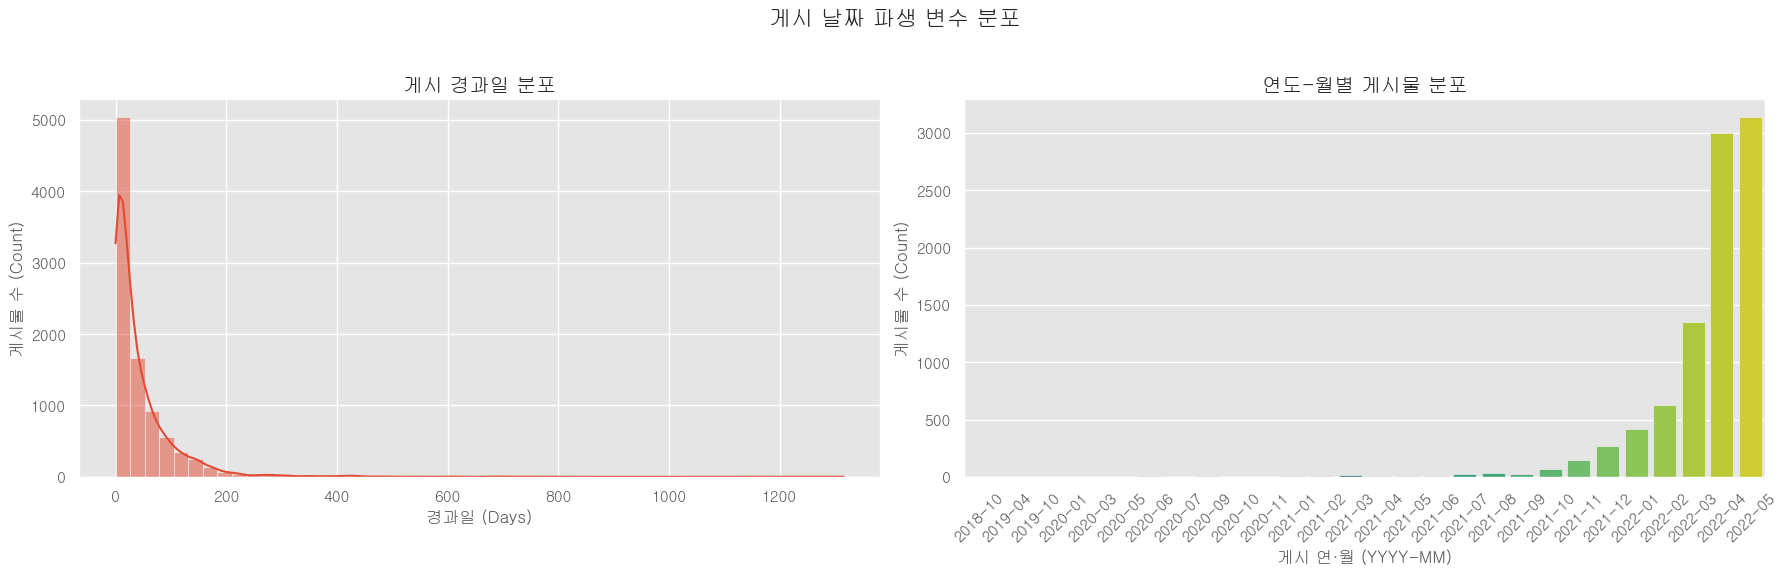

In [54]:
# 1. 'date_posted'를 datetime 타입으로 변환
df['date_posted'] = pd.to_datetime(df['date_posted'], dayfirst=True)

# 2. 분석 기준일(데이터셋 중 가장 마지막 일자) 지정
analysis_date = df['date_posted'].max()

# 3. 파생 변수 생성
df['days_on_market'] = (analysis_date - df['date_posted']).dt.days
df['post_year'] = df['date_posted'].dt.year
df['post_month'] = df['date_posted'].dt.month
df['post_year_month'] = df['date_posted'].dt.to_period('M').astype(str)

# 4. 요약 확인
print("--- 생성된 피처 확인 (상위 5개) ---")
print(df[['date_posted', 'days_on_market', 'post_year', 'post_month', 'post_year_month']].head())

print("\n--- '게시 경과일(days_on_market)' 기초 통계량 ---")
print(df['days_on_market'].describe())

# 5. 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('게시 날짜 파생 변수 분포', fontsize=16, fontweight='bold')

# (1) 전체 게시 경과일 분포
sns.histplot(df['days_on_market'], bins=50, ax=axes[0], kde=True)
axes[0].set_title('게시 경과일 분포')
axes[0].set_xlabel('경과일 (Days)')
axes[0].set_ylabel('게시물 수 (Count)')

# (2) 연-월별 게시물 분포
order = sorted(df['post_year_month'].unique())
sns.countplot(x='post_year_month', data=df, ax=axes[1], order=order, palette='viridis')
axes[1].set_title('연도-월별 게시물 분포')
axes[1].set_xlabel('게시 연·월 (YYYY-MM)')
axes[1].set_ylabel('게시물 수 (Count)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


EDA 결과 연도-월별 게시물 분포에선 최근 데이터가 집중적으로 포함되어 있는 것을 확인, <br>
게시 결과일 분포에선 매물이 거의 대부분 게시된지 100일 이내임을 파악 

### 전처리 date_posted

In [55]:
# 날짜 형식 변환
df['date_posted'] = pd.to_datetime(df['date_posted'], dayfirst=True)

# 기준일
analysis_date = df['date_posted'].max()

# 파생 변수 생성
df['days_on_market'] = (analysis_date - df['date_posted']).dt.days
df['post_year'] = df['date_posted'].dt.year
df['post_month'] = df['date_posted'].dt.month
df['post_year_month'] = df['date_posted'].dt.to_period('M').astype(str)

In [56]:
# 파생 변수 값 샘플 출력
print("=== 파생 변수 샘플 데이터 ===")
print(df[['date_posted', 'days_on_market', 'post_year', 'post_month', 'post_year_month']].head())

# days_on_market 기초 통계량
print("\n=== 게시 경과일(days_on_market) 통계량 ===")
print(df['days_on_market'].describe())

# 게시 연도별, 연-월별 게시물 수 집계
print("\n=== 연도별 게시물 수 ===")
print(df['post_year'].value_counts().sort_index())

print("\n=== 연-월별 게시물 수 (상위 10개) ===")
print(df['post_year_month'].value_counts().sort_index().head(10))


=== 파생 변수 샘플 데이터 ===
  date_posted  days_on_market  post_year  post_month post_year_month
0  2022-05-13               0       2022           5         2022-05
1  2022-01-14             119       2022           1         2022-01
2  2022-05-05               8       2022           5         2022-05
3  2022-04-30              13       2022           4         2022-04
4  2022-05-13               0       2022           5         2022-05

=== 게시 경과일(days_on_market) 통계량 ===
count    9171.000000
mean       43.748228
std        65.153319
min         0.000000
25%         6.000000
50%        23.000000
75%        56.000000
max      1315.000000
Name: days_on_market, dtype: float64

=== 연도별 게시물 수 ===
post_year
2018       1
2019       2
2020      16
2021     623
2022    8529
Name: count, dtype: int64

=== 연-월별 게시물 수 (상위 10개) ===
post_year_month
2018-10    1
2019-04    1
2019-10    1
2020-01    1
2020-03    1
2020-05    2
2020-06    4
2020-07    1
2020-09    4
2020-10    1
Name: count, dtype: int64


### EDA body_conditon, mechanical_condition

--- 'body_condition' 분포 ---
body_condition
Perfect inside and out                8813
No accidents, very few faults          208
A bit of wear & tear, all repaired     119
Normal wear & tear, a few issues        31
Name: count, dtype: int64


--- 'mechanical_condition' 분포 ---
mechanical_condition
Perfect inside and out              9023
Minor faults, all fixed              136
Major faults fixed, small remain       8
Ongoing minor & major faults           3
Major faults, all fixed                1
Name: count, dtype: int64


--- 'body_condition' vs 'mechanical_condition' 교차표 ---
mechanical_condition                Major faults fixed, small remain  \
body_condition                                                         
A bit of wear & tear, all repaired                                 2   
No accidents, very few faults                                      0   
Normal wear & tear, a few issues                                   4   
Perfect inside and out                                

C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\291109022.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='price_in_aed', y='body_condition', ax=axes[0], palette='pastel')
C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\291109022.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='price_in_aed', y='mechanical_condition', ax=axes[1], palette='pastel')


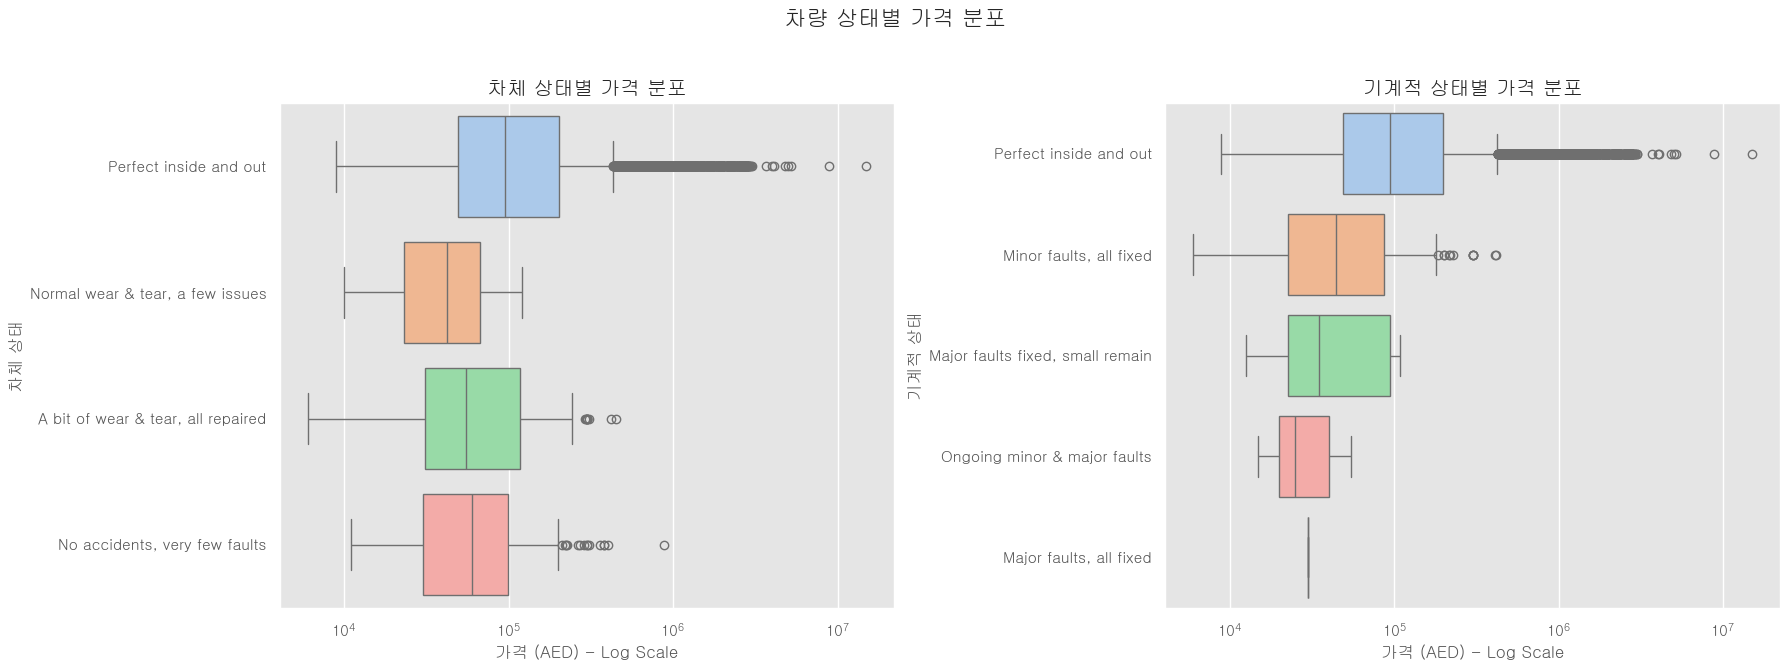

In [57]:
# --- 1. 컬럼의 카테고리 분포 확인 ---
print("--- 'body_condition' 분포 ---")
print(df['body_condition'].value_counts())
print("\n" + "="*40 + "\n")

print("--- 'mechanical_condition' 분포 ---")
print(df['mechanical_condition'].value_counts())
print("\n" + "="*40 + "\n")


# --- 2. 두 변수 간의 관계 확인 ---
print("--- 'body_condition' vs 'mechanical_condition' 교차표 ---")
crosstab_result = pd.crosstab(df['body_condition'], df['mechanical_condition'])
print(crosstab_result)
print("\n" + "="*40 + "\n")


# --- 3. 각 변수와 가격의 관계 시각화 ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('차량 상태별 가격 분포', fontsize=16, fontweight='bold')

# body_condition vs price_in_aed
sns.boxplot(data=df, x='price_in_aed', y='body_condition', ax=axes[0], palette='pastel')
axes[0].set_title('차체 상태별 가격 분포')
axes[0].set_xlabel('가격 (AED) - Log Scale')
axes[0].set_ylabel('차체 상태')
axes[0].set_xscale('log')

# mechanical_condition vs price_in_aed
sns.boxplot(data=df, x='price_in_aed', y='mechanical_condition', ax=axes[1], palette='pastel')
axes[1].set_title('기계적 상태별 가격 분포')
axes[1].set_xlabel('가격 (AED) - Log Scale')
axes[1].set_ylabel('기계적 상태')
axes[1].set_xscale('log')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

바디와 기계적 컨디션이 모두 우수할 수록 평균, 중위 가격이 높아지는 것을 확인<br>
초고가는 최상급 컨디션에서 몰려있고, 컨디션이 않좋을 수록 가격이 낮고 단조롭게 형성이 됨을 확인

### 전처리 body_condition, mechanical_condition

In [58]:
# 등급 사전 정의
body_map = {
    'Perfect inside and out': 3,
    'Normal wear & tear, a few issues': 2,
    'A bit of wear & tear, all repaired': 1,
    'No accidents, very few faults': 0,
    'Other': 0
}
df['body_condition_ord'] = df['body_condition'].map(body_map)

In [59]:
# 기계 컨디션 등급 사전 정의
mech_map = {
    'Perfect inside and out': 3,
    'Minor faults, all fixed': 2,
    'Major faults fixed, small remain': 1,
    'Major faults, all fixed': 1,
    'Ongoing minor & major faults': 0,
    'Other': 0
}

# 순서형 인코딩 적용
df['mechanical_condition_ord'] = df['mechanical_condition'].map(mech_map)

### EDA model, mootrs_trim

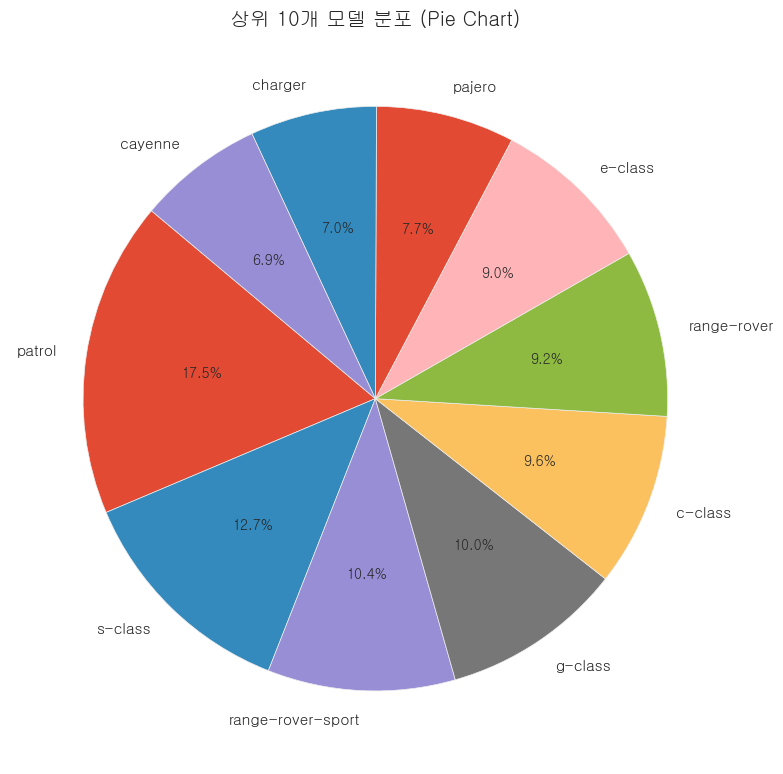

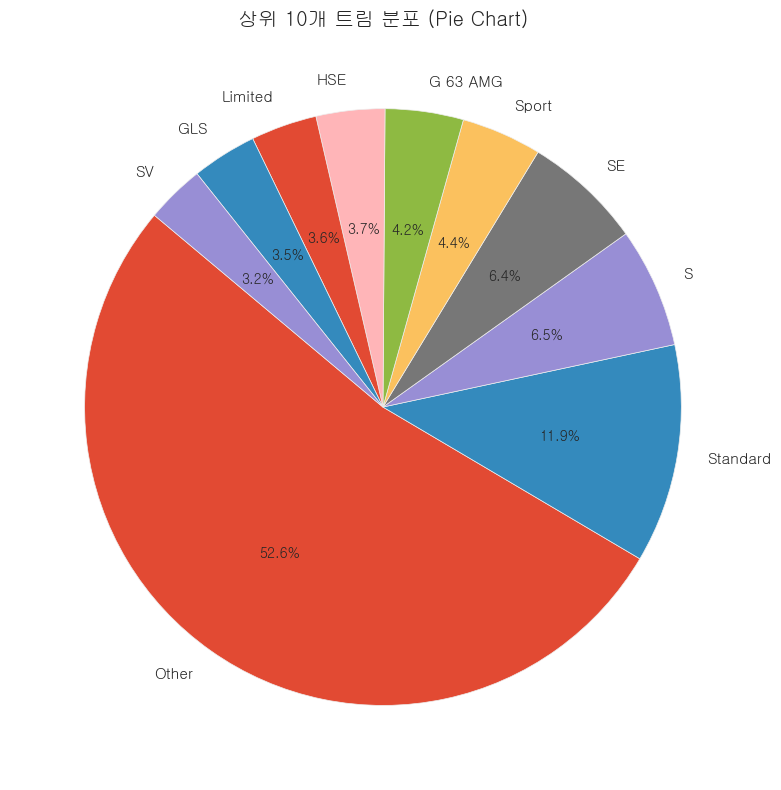

In [60]:
# 1. model 컬럼: 상위 10개 모델 집계
model_counts = df['model'].value_counts().head(10)

plt.figure(figsize=(8, 8))
plt.pie(model_counts.values, labels=model_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('상위 10개 모델 분포 (Pie Chart)')
plt.tight_layout()
plt.show()

# 2. motors_trim 컬럼: 상위 10개 트림 집계
trim_counts = df['motors_trim'].value_counts().head(10)

plt.figure(figsize=(8, 8))
plt.pie(trim_counts.values, labels=trim_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('상위 10개 트림 분포 (Pie Chart)')
plt.tight_layout()
plt.show()

상위 10개 모델은 전체 시장에서 틀정 모델이 높은 비중을 차지 하고 있으며 나머지 모델은 비교적 분산<br>
상위 10개 트림은 소수의 트림이 시장 점유율을 주도하고, 나머지는 개별 비율이 낮게 나타남<br>
추가로 모델과 트림은 연관성이 있을 것이라 판단 교차표를 이용해 상관관계를 평가 

In [61]:
# 연관성 분석 (교차표)

# 'motors_trim'과 'model' 컬럼 간의 교차표를 생성합니다.
crosstab_result = pd.crosstab(df['motors_trim'], df['model'])

print("--- 'motors_trim' vs 'model' 교차표  ---")
print(crosstab_result)

--- 'motors_trim' vs 'model' 교차표  ---
model                  1-series  124-spider  156159  2  2-series  2008  \
motors_trim                                                              
1.6 T                         0           0       0  0         0     0   
1.6T I4 4WD                   0           0       0  0         0     0   
1/2 Ultra                     0           0       0  0         0     0   
100D                          0           0       0  0         0     0   
110                           0           0       0  0         0     0   
...                         ...         ...     ... ..       ...   ...   
xDrive35i M Sport             0           0       0  0         0     0   
xDrive40i                     0           0       0  0         0     0   
xDrive50i Exclusive           0           0       0  0         0     0   
xDrive50i Luxury-Line         0           0       0  0         0     0   
xDrive50i M Sport             0           0       0  0         0     0   


EDA 결과 motors_trim과 model의 연관성을 교차표로 분석해 결과,<br>
특정트림이 단 하나의 모델에만 종속는 강한 계층관계 확인

### 전처리 model, motors_trim

In [62]:
# 상위 10개만 남기고 나머지 'Other'로 통합
top_models = df['model'].value_counts().head(10).index
df['model_grouped'] = df['model'].apply(lambda x: x if x in top_models else 'Other')

top_trims = df['motors_trim'].value_counts().head(10).index
df['trim_grouped'] = df['motors_trim'].apply(lambda x: x if x in top_trims else 'Other')

# 원-핫 인코딩
df = pd.get_dummies(df, columns=['model_grouped', 'trim_grouped'], prefix=['model', 'trim'], drop_first=False)

### EDA year

C:\Users\Admin\AppData\Local\Temp\ipykernel_18272\1041047424.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='year', order=df['year'].value_counts().index, palette='mako')


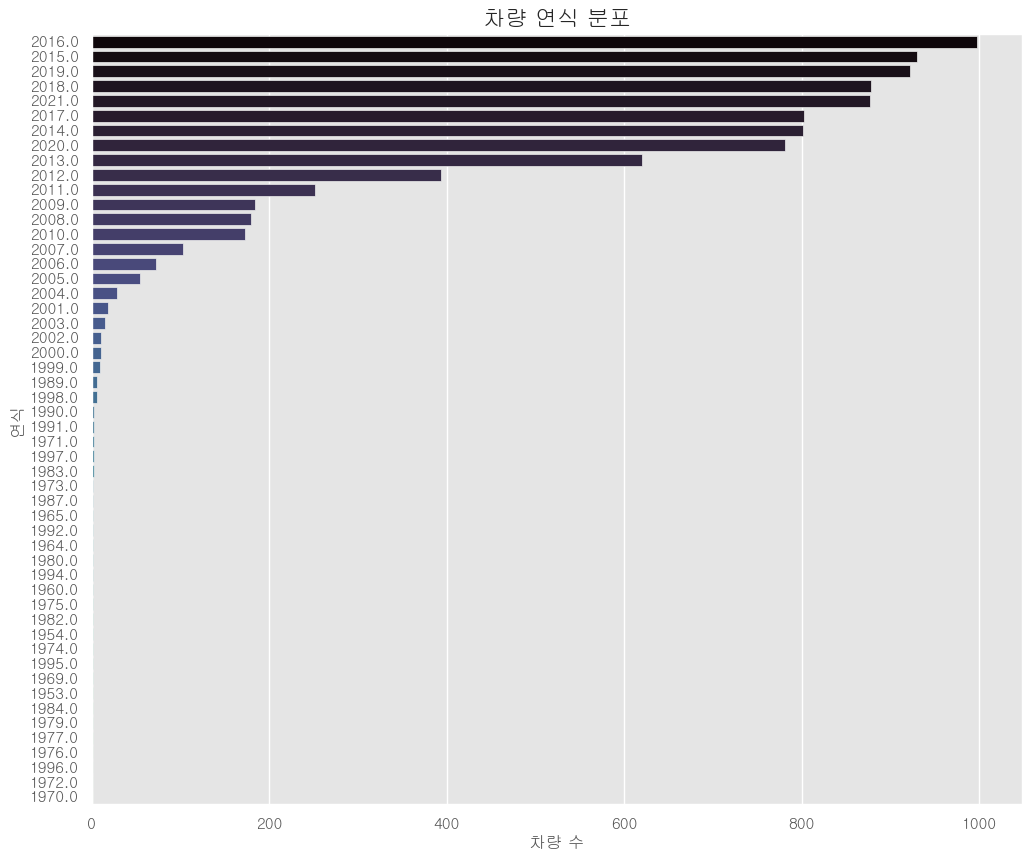

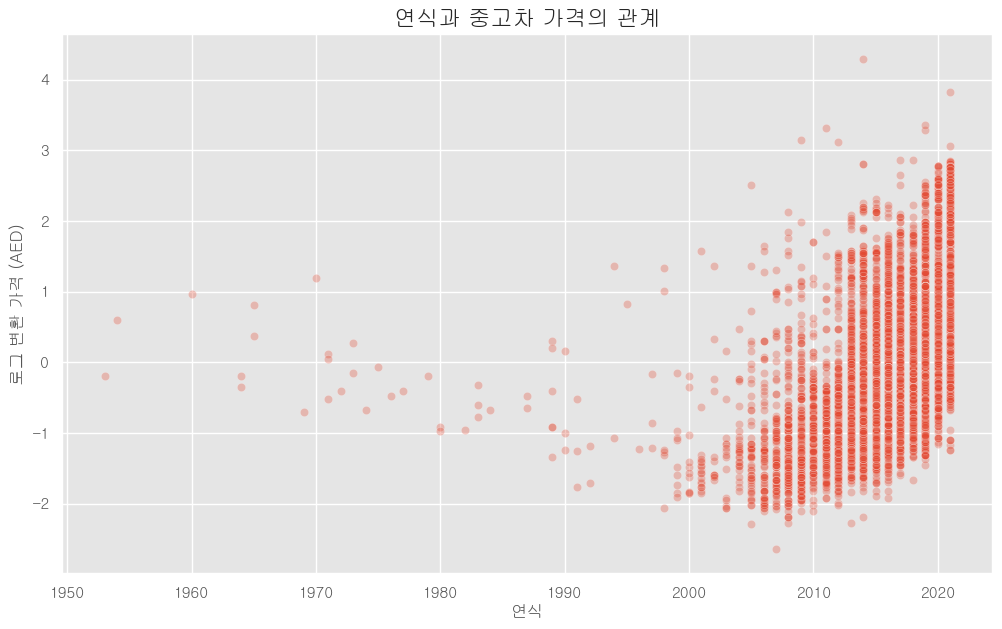

In [63]:
# 1. 연식별 차량 분포 
plt.figure(figsize=(12, 10))
sns.countplot(data=df, y='year', order=df['year'].value_counts().index, palette='mako')
plt.title('차량 연식 분포', fontsize=16)
plt.xlabel('차량 수', fontsize=12)
plt.ylabel('연식', fontsize=12)
plt.show()

# 2. 연식과 가격의 관계
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='year', y='scaled_log_price_in_aed', alpha=0.3)
plt.title('연식과 중고차 가격의 관계', fontsize=16)
plt.xlabel('연식', fontsize=12)
plt.ylabel('로그 변환 가격 (AED)', fontsize=12)
plt.show()

EDA의 결과 차량 연식은 최신 연도에 집중된 분포를 보이며,<br>
연식은 가격결정의 주요 변수로서 직선에 가까운 음의 상관관계가 시각적으로 확인<br>

# EDA & 전처리 마지막 점검

### horsepower, no_of_cylinders: 결측, 이상치, 스케일 전처리 절차

In [64]:
# 대체 후 남은 결측치 개수 확인
print("no_of_cylinders_numeric 결측치:", df_knn['no_of_cylinders_numeric'].isnull().sum())
print("horsepower_numeric 결측치:", df_knn['horsepower_numeric'].isnull().sum())


no_of_cylinders_numeric 결측치: 0
horsepower_numeric 결측치: 0


### *_backup, *_was_missing 등 플래그 계열: 필요 목적 아닌 경우 최종 모델 투입 전 제거

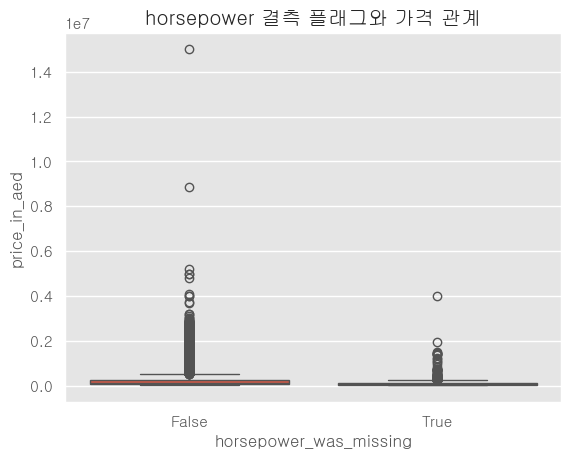

In [65]:
sns.boxplot(data=df_knn, x='horsepower_was_missing', y='price_in_aed')
plt.title('horsepower 결측 플래그와 가격 관계')
plt.show()

In [66]:
# 플래그, 백업 컬럼 최종 삭제
drop_cols = [col for col in df_knn.columns if col.endswith('_was_missing') or col.endswith('_backup')]
df_knn = df_knn.drop(columns=drop_cols)

### 원-핫/파생 컬럼 생성 후 불필요한 원본 컬럼, 중복 변수를 반드시 한 번에 정리

In [67]:
print(df_knn.columns)
print(df.columns)

Index(['title', 'price_in_aed', 'kilometers', 'body_condition',
       'mechanical_condition', 'seller_type', 'body_type', 'no_of_cylinders',
       'transmission_type', 'regional_specs', 'horsepower', 'fuel_type',
       'steering_side', 'year', 'color', 'emirate', 'motors_trim', 'company',
       'model', 'date_posted', 'was_missing', 'horsepower_numeric',
       'no_of_cylinders_numeric'],
      dtype='object')
Index(['price_in_aed', 'kilometers', 'body_condition', 'mechanical_condition',
       'body_type', 'no_of_cylinders', 'transmission_type', 'regional_specs',
       'horsepower', 'fuel_type', 'year', 'color', 'emirate', 'motors_trim',
       'company', 'model', 'date_posted', 'year_backup', 'was_missing',
       'motors_trim_backup', 'motors_trim_was_missing', 'horsepower_numeric',
       'no_of_cylinders_numeric', 'log_price_in_aed',
       'scaled_log_price_in_aed', 'body_Coupe', 'body_Other', 'body_SUV',
       'body_Sedan', 'company_te', 'seller_Dealer',
       'seller_Dea

In [68]:
cols_to_drop = [
    'body_condition',
    'mechanical_condition',
    
    'transmission_type',
    'fuel_type',
    'regional_specs',

    'color',
    'emirate',

    'model',
    'motors_trim',

    'year_backup',
    'was_missing',
    'motors_trim_backup',
    'motors_trim_was_missing',

    'horsepower',
    'no_of_cylinders',

    'date_posted','post_year_month', 

    'body_type',

    'seller_type', 
 
    
    'company',

    'price_in_aed', 'log_price_in_aed'
]
cols_to_drop_exist = [col for col in cols_to_drop if col in df.columns]
df = df.drop(columns=cols_to_drop_exist)
print(f"삭제된 컬럼: {cols_to_drop_exist}")
print(f"남은 컬럼 리스트: {df.columns.tolist()}")


삭제된 컬럼: ['body_condition', 'mechanical_condition', 'transmission_type', 'fuel_type', 'regional_specs', 'color', 'emirate', 'model', 'motors_trim', 'year_backup', 'was_missing', 'motors_trim_backup', 'motors_trim_was_missing', 'horsepower', 'no_of_cylinders', 'date_posted', 'post_year_month', 'body_type', 'company', 'price_in_aed', 'log_price_in_aed']
남은 컬럼 리스트: ['kilometers', 'year', 'horsepower_numeric', 'no_of_cylinders_numeric', 'scaled_log_price_in_aed', 'body_Coupe', 'body_Other', 'body_SUV', 'body_Sedan', 'company_te', 'seller_Dealer', 'seller_Dealership/Certified Pre-Owned', 'seller_Owner', 'transmission_type_bin', 'fuel_type_bin', 'regional_specs_bin', 'color_Black', 'color_Grey', 'color_Other', 'color_White', 'emirate_ Abu Dhabi', 'emirate_ Dubai', 'emirate_ Sharjah', 'emirate_Other', 'days_on_market', 'post_year', 'post_month', 'body_condition_ord', 'mechanical_condition_ord', 'model_Other', 'model_c-class', 'model_cayenne', 'model_charger', 'model_e-class', 'model_g-class', 

# 모델 학습

In [69]:
# 타깃 및 피처 지정
target = 'scaled_log_price_in_aed'   
X = df.drop(columns=[target])
y = df[target]

# 학습/검증 데이터 분할 (8:2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### HistGradientBoostingRegressor

In [70]:
hgb_model = HistGradientBoostingRegressor(
    max_iter=500,
    max_depth=15,
    random_state=42
)
hgb_model.fit(X_train, y_train)
y_pred_hg = hgb_model.predict(X_val)

print('XGBoost RMSE:', mean_squared_error(y_val, y_pred_hg, squared=False))
print('XGBoost R2:', r2_score(y_val, y_pred_hg))

XGBoost RMSE: 0.2463549013836317
XGBoost R2: 0.9347540850934641


c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 랜덤포레스트

In [71]:
rf_model = RandomForestRegressor(
    n_estimators=500,      
    max_depth=15,          
    min_samples_split=5,    
    n_jobs=-1,              
    random_state=42         
)

# 학습
rf_model.fit(X_train, y_train)

# 예측
y_pred_lr = rf_model.predict(X_val)

# RMSE(루트 평균제곱오차)
rmse = mean_squared_error(y_val, y_pred_lr, squared=False)
print('RandomForest RMSE:', rmse)

# R2(결정계수)
r2 = r2_score(y_val, y_pred_lr)
print('RandomForest R2:', r2)


RandomForest RMSE: 0.27482416972926443
RandomForest R2: 0.9188028548277155


c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### XGBoost

In [72]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=42,
    verbosity=1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

# 예측 및 평가
y_pred_xgb = xgb_model.predict(X_val)
print('XGBoost RMSE:', mean_squared_error(y_val, y_pred_xgb, squared=False))
print('XGBoost R2:', r2_score(y_val, y_pred_xgb))

[0]	validation_0-rmse:1.08734
[100]	validation_0-rmse:0.26233
[200]	validation_0-rmse:0.25035
[300]	validation_0-rmse:0.24475
[400]	validation_0-rmse:0.24218
[500]	validation_0-rmse:0.24093
[568]	validation_0-rmse:0.24091
XGBoost RMSE: 0.240691360025899
XGBoost R2: 0.9377195255019481


c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# 하이퍼파라미터 튜닝

In [73]:
models = {
    'HistGBR': (
        HistGradientBoostingRegressor(random_state=42),
        {
            'learning_rate': [0.01, 0.05, 0.1],
            'max_iter': [100, 200, 500],
            'max_depth': [5, 10, 15]
        }
    ),
    'RandomForest': (
        RandomForestRegressor(random_state=42, n_jobs=-1),
        {
            'n_estimators': [100, 300, 500],
            'max_depth': [10, 15, 20],
            'min_samples_split': [2, 5, 10]
        }
    ),
    'XGBoost': (
        xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
        {
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [100, 300, 500],
            'max_depth': [5, 10, 15],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
        }
    ),
}

In [74]:
results = {}

for name, (model, param_dist) in models.items():
    print(f"== {name} RandomizedSearchCV 시작 ==")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=20,
        scoring='neg_root_mean_squared_error',
        cv=3,
        verbose=2,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    
    # 최적 모델로 검증집합 예측
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_val)
    
    # RMSE, R2 계산
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    r2 = r2_score(y_val, y_pred)
    
    print(f"[{name}] Best CV RMSE (neg_root_mean_squared_error): {-search.best_score_:.4f}")
    print(f"[{name}] Validation set RMSE: {rmse:.4f}")
    print(f"[{name}] Validation set R2 score: {r2:.4f}")
    print(f"[{name}] Best Params: {search.best_params_}")
    
    results[name] = {
        'best_cv_rmse': -search.best_score_,
        'val_rmse': rmse,
        'val_r2': r2,
        'best_params': search.best_params_
    }

print("\n=== 전체 모델 비교 결과 ===")
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(results)


== HistGBR RandomizedSearchCV 시작 ==
Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[HistGBR] Best CV RMSE (neg_root_mean_squared_error): 0.2531
[HistGBR] Validation set RMSE: 0.2488
[HistGBR] Validation set R2 score: 0.9334
[HistGBR] Best Params: {'max_iter': 500, 'max_depth': 15, 'learning_rate': 0.05}
== RandomForest RandomizedSearchCV 시작 ==
Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[RandomForest] Best CV RMSE (neg_root_mean_squared_error): 0.2736
[RandomForest] Validation set RMSE: 0.2728
[RandomForest] Validation set R2 score: 0.9200
[RandomForest] Best Params: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 15}
== XGBoost RandomizedSearchCV 시작 ==
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[XGBoost] Best CV RMSE (neg_root_mean_squared_error): 0.2512
[XGBoost] Validation set RMSE: 0.2448
[XGBoost] Validation set R2 score: 0.9356
[XGBoost] Best Params: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

=== 전체 모델 비교 결과 ===
{ 'HistGBR': { 'best_cv_rmse': np.float64(0.2531459658699651),
               'best_params': { 'learning_rate': 0.05,
                                'max_depth': 15,
                                'max_iter': 500},
               'val_r2': np.float64(0.9334398382923917),
               'val_rmse': np.float64(0.2488236914224861)},
  'RandomForest': { 'best_cv_rmse'

c:\Users\Admin\miniconda3\envs\hi_ml_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# 결론

본 프로젝트에서는 중고차 데이터의 다양한 특성과 수많은 전처리 과정을 거쳐,<br>
세가지 대표 회귀 앙상블 모델인(HistGBR, RandomForest,XGBoost)로 중고차 가격 예측 실험을 진행하였습니다.<br>
최종 모델로는 XGBoost가 rmse값이 0.245, R² 값이 9.36%로 매우 좋은 성능, 매우 신뢰도가 높은 모델임을 확인하였습니다

# 최종 선택 모델 : XGBOoost